In [2]:
%load_ext autoreload
%autoreload 2

import importlib, sys
import hex_check as hc_mod

def deep_reload(module_name: str):
    """Reload a module and all its submodules that start with it."""
    importlib.invalidate_caches()
    mods_to_reload = [name for name in sys.modules if name.startswith(module_name)]
    for name in sorted(mods_to_reload, reverse=True):
        try:
            importlib.reload(sys.modules[name])
            print(f"Reloaded {name}")
        except Exception as e:
            print(f"Could not reload {name}: {e}")

# Force a clean reload order: deps first, then dependents
deep_reload("hex_check")

# Rebuild the object so it picks up new config/code
hc = hc_mod.build_hex_check(plot=False, new=True)

import os
import re

import numpy as np
from matplotlib import pyplot as plt

from numpy import seterr as np_seterr
from scipy.optimize import curve_fit

from extinction_plots import plot_fft_peak, \
    plot_1d_histogram, plot_normalized_histogram
from extinction_functions import simulate_delta_train, get_delta_trains_from_hex, \
    get_three_fold_coincidence_points, report_results_with_error, symmetric_mod, \
    lorentzian, combine_periods

from socketudp.extinction_plots import plot_2d_histogram_time_vs_event_number
from socketudp.extinction_functions import get_delta_trains_per_event_from_hex

# np_seterr(all='raise')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reloaded hex_check_config
Reloaded hex_check_classes

Reloaded hex_check
Using input file data_20250711_024604.dat
# Peakfinding Length: 1000000000
# Number of subevents: 90
# Raw Data Length: 1
# Peakfinding Threshold: -300
# Peak height event count: 70
# Peak area event count: 210
# FPGA Test Mode: 0
# top_fmc228_pcie_v24.bit
Found 70 events in the file.
Event 6434-1 has 50 sub-events.
Payload length 8 (eeee02eeaaaaaaaaccccccccd6dd7a70a2fc0000e9dd7a70ebfb00007edf7a7035fd000092df7a70ddfd000025e17a7050fb0000dae27a7075fc0000e3e27a7077fe000013e37a70a3ff000071e47a70bbfc000076e47a5015fd000082e47a708efa00008be47a7082fa000018e67a70fcfd00001ce67a70ecfd000023e67a6079fd000034e67a70c4fd0000c7e77a709cfd0000dae77a400afc00006be97a7004fe000013eb7a70affb0000d5ec7a40b0fd000062ee7a70fbfa00005af17a7098ff0000aff17a7074fd0000b7f17a505bfd0000bdf17a4087fe0000cef17a708cfd00005cf37a70fafe00006ff37a70a0fd000012f57a40f8fb000

In [3]:
from socketudp.hex_check_classes import convert_voltage, NewEvent, PeakArea


def plot_raw_data(_hex_check, n_subevents = np.inf, n_events = np.inf, plotting_units ="volts", figsize = (8, 8), t_range=(0, np.inf), y_range=None):
    # grouped = _hex_check.raw_data_dataframe.groupby(["internal_event_number", "sub_event_number"])
    grouped = _hex_check.raw_data_dataframe.groupby(["internal_event_number"])
    # for (internal_event, sub_event), group in grouped:
    for (internal_event), group in grouped:
        if isinstance(internal_event, tuple):
            internal_event = internal_event[0]
        # if sub_event + 1 > n_subevents or internal_event > n_events:
        if internal_event > n_events:
            continue
        t_arrays = []
        channel_arrays = []
        for ch in [1, 2, 3, 4]:
            ch_data = group[group["channel_number"] == ch]["data"].values
            y_vals = convert_voltage(ch_data) if plotting_units == "volts" else ch_data
            t_data = np.array(range(len(ch_data)))

            t_mask = (t_range[0] < t_data) & (t_data < t_range[1])
            t_data = t_data[t_mask]
            y_vals = y_vals[t_mask]

            # y_mask = (y_range[0] < y_vals) & (y_vals < y_range[1])
            # t_data = t_data[y_mask]
            # y_vals = y_vals[y_mask]

            t_arrays.append(t_data.tolist())
            channel_arrays.append(y_vals.tolist())
        plot_event_grid(_hex_check, channel_arrays, internal_event,
                                   "Raw Data - Event", "raw",
                                   # sub_event=sub_event
                        n_plots=4, channel_in=2, figsize=figsize, t_data=t_arrays, y_range=y_range)


def plot_event_grid(_hex_check, grouped_data: list[list[float]],
                    internal_event: int,
                    title_prefix: str = '',
                    file_prefix: str = '',
                    sub_event: int = None,
                    t_data: list[list[float]] = None,
                    y_range: list[list[float]] = None,
                    optional_note=None, plotting_units="volts",
                    n_plots=4, channel_in=4, figsize=(10, 8)):
    """
    Plots a 2x2 grid using the grouped data.

    Parameters:
        grouped_data: List of 4 lists (one per channel). Each list contains Y-axis values to plot.
        internal_event: Event number for labeling and saving.
        title_prefix: Title string prefix (e.g. "Raw Data - Event").
        file_prefix: File prefix for saved image (e.g. "raw").
        sub_event: (Optional) Sub-event number for labeling.
        t_data: Optional list of 4 lists (one per channel). Each list contains X-axis values to plot.
        optional_note: Optional note string (e.g. "Raw Data - Event").
        plotting_units: Optional units string (e.g. "volts").
    """
    if n_plots == 1:
        fig, axes = plt.subplots(1, 1, figsize=figsize)
        axes = np.array([axes])
    else:
        fig, axes = plt.subplots(4, 1, figsize=figsize)

    title = f"{title_prefix} - Event {internal_event}"
    if sub_event is not None:
        title += f", Subevent {sub_event}"
    time_str = _hex_check.file_creation_date.strftime("%Y-%m-%d %H:%M:%S")
    title += f"\n{_hex_check.file_name} ({time_str})"

    fig.suptitle(title, fontsize=14)

    output_path = f"img/{_hex_check.folder_name}/{file_prefix}_{internal_event}.png"
    if not os.path.exists(f"img/{_hex_check.folder_name}"):
        os.mkdir(f"img/{_hex_check.folder_name}")

    if optional_note:
        # annotate below the bottom-right axis
        axes[1, 1].annotate(optional_note, xy = (1.0, -0.2), xycoords = 'axes fraction',
                        ha='right', va='top', fontsize=10)

    if not t_data:
        t_data = [[], [], [], []]  # Initialize t_data if not provided

    # grouped_data and t_data are lists like:
    # [  [ channel_1 data],
    #    [ channel_2 data],
    #    [ channel_3 data],
    #    [ channel_4 data],  ]
    # with the possibility of some of those lists being empty if that channel has no data

    for i, (ax, channel_t, channel_data) in enumerate(zip(axes.flatten(), t_data, grouped_data)):
        channel = i + 1
        if n_plots == 1:
            channel = channel_in
            channel_t = t_data[channel - 1]
            channel_data = grouped_data[channel - 1]
        if channel_data:
            if channel_t:
                # if the range is too large, convert to us or ms
                if max(channel_t) - min(channel_t) > 1e6:
                    channel_t = [t / 1e6 for t in channel_t]
                    units = 'ms'
                elif max(channel_t) - min(channel_t) > 3.5e3:
                    channel_t = [t / 1e3 for t in channel_t]
                    units = 'μs'
                else:
                    units = 'ns'
                ax.plot(channel_t, channel_data, label=f"Channel {channel}")
            else:
                ax.plot(channel_data, label=f"Channel {channel}")
                units = 'ns'
            ax.set_title(f"Channel {channel}")
            ax.legend()
            ax.grid(True)
        else:
            units = 'ns'
            ax.text(0.5, 0.5, "No Data", fontsize=12, ha="center", va="center")
            ax.set_title(f"Channel {channel}")

        if y_range:
            # set y-range to y_range[0] to y_range[1]
            ax.set_ylim(y_range)

        if i >= 2 or units != 'ns':
            ax.set_xlabel(f"Time ({units})")
        if i % 2 == 0:
            ax.set_ylabel("Voltage (V)" if plotting_units == "volts" else "Raw Data")

    plt.tight_layout(rect=(0, 0.01, 1, 0.99))
    plt.savefig(output_path)
    plt.show()
    plt.close()

# plot_raw_data(hc, n_events=5, n_subevents=99, figsize=(20, 14),
#               # t_range=(1130,1330),
#               # y_range=(-0.03, 0.005),
#               )

In [4]:
# Calculate average width in time of peaks from peak area packets

peak_areas: list[PeakArea] = []
for event in hc.event_buffer:
    event: NewEvent
    for subevent in event.sub_events:
        print(subevent.peak_area_list)
        peak_areas += subevent.peak_area_list[1]

print(peak_areas)

peak_widths = [p.peak_width for p in peak_areas]



IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Peak widths (n=54601): mean=27.9295 samples, median=16, std=28.3092
min=4, max=260


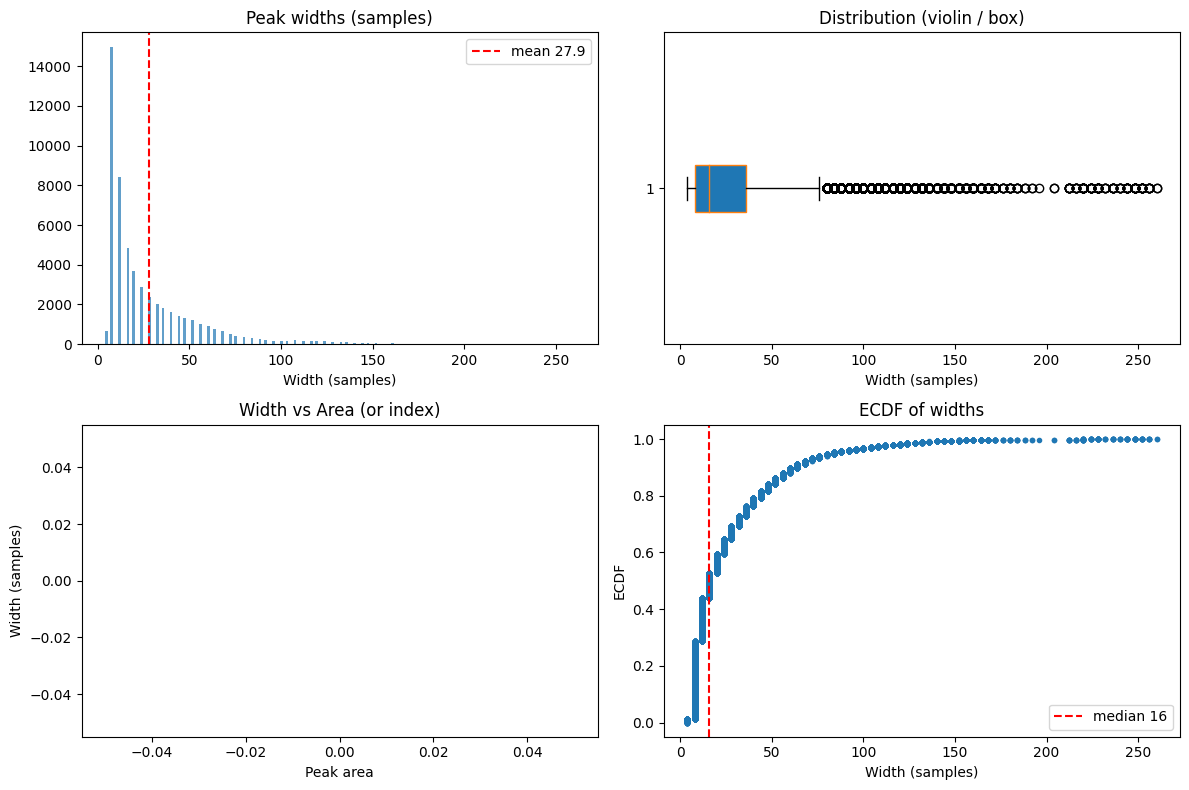

In [5]:
# Smart visualization of peak widths (samples and, if possible, seconds)
# Config (adjust as needed)
manual_sample_period = None   # e.g. 1/125e6  -> set to seconds/sample if you know it, otherwise None
use_log_scales = True         # log-log scatter for width vs area
save_figures = None           # filepath (e.g. "peak_widths_summary.png") or None to skip saving

# --- collect widths/areas robustly from peak_areas (assumes 'peak_areas' exists) ---
import math
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set(style="whitegrid")
    _use_sns = True
except Exception:
    _use_sns = False

# Build arrays
_widths = []
_areas = []
for p in peak_areas:
    if p is None:
        continue
    w = getattr(p, "peak_width", None)
    if w is None:
        continue
    try:
        w = float(w)
    except Exception:
        continue
    # guard against negative or nan widths
    if not math.isfinite(w) or w <= 0:
        continue
    _widths.append(w)
    a = getattr(p, "peak_area", None)
    try:
        a = float(a) if a is not None else np.nan
    except Exception:
        a = np.nan
    _areas.append(a)

_widths = np.array(_widths)
_areas = np.array(_areas, dtype=float) if _areas else np.array([])

if _widths.size == 0:
    print("No valid peak widths found in `peak_areas`.")
else:
    # --- detect sample_period intelligently (samples -> seconds) ---
    def detect_sample_period(objs, fallback_hc=None, manual=None):
        if manual is not None:
            return float(manual)
        # search for direct sample_period-like fields
        for attr in ("sample_period", "dt", "time_per_sample"):
            for o in objs:
                val = getattr(o, attr, None)
                if val is not None:
                    return float(val)
        # search for sample rate (Hz) and invert
        for attr in ("sample_rate", "sampling_rate", "fs", "sr"):
            for o in objs:
                val = getattr(o, attr, None)
                if val is not None:
                    try:
                        val = float(val)
                        return 1.0 / val if val != 0 else None
                    except Exception:
                        pass
        # try fallback object (hc) if provided
        if fallback_hc is not None:
            for attr in ("sample_period", "dt", "time_per_sample"):
                val = getattr(fallback_hc, attr, None)
                if val is not None:
                    return float(val)
            for attr in ("sample_rate", "sampling_rate"):
                val = getattr(fallback_hc, attr, None)
                if val is not None:
                    val = float(val)
                    return 1.0 / val if val != 0 else None
        return None

    sample_period = detect_sample_period(peak_areas, fallback_hc=globals().get("hc", None), manual=manual_sample_period)
    widths_time = _widths * sample_period if sample_period is not None else None

    # --- summary statistics ---
    import statistics
    count = _widths.size
    mean_samples = float(_widths.mean())
    med_samples = float(np.median(_widths))
    std_samples = float(_widths.std(ddof=1)) if count > 1 else 0.0
    min_samples, max_samples = float(_widths.min()), float(_widths.max())

    # area-weighted mean when area available and finite
    wmean_samples = None
    if _areas.size == count:
        finite_mask = np.isfinite(_areas)
        if finite_mask.any():
            denom = _areas[finite_mask].sum()
            if denom != 0:
                wmean_samples = float(np.average(_widths[finite_mask], weights=_areas[finite_mask]))

    # print concise summary
    print(f"Peak widths (n={count}): mean={mean_samples:.6g} samples, median={med_samples:.6g}, std={std_samples:.6g}")
    print(f"min={min_samples:.6g}, max={max_samples:.6g}")
    if wmean_samples is not None:
        print(f"area-weighted mean = {wmean_samples:.6g} samples")
    if sample_period is not None:
        print(f"Sample period detected: {sample_period:.6g} s/sample -> mean time = {mean_samples*sample_period:.6g} s")

    # --- plotting: histogram+KDE, violin/box, width vs area, ECDF, plus time histogram if available ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    ax_hist, ax_violin, ax_scatter, ax_ecdf = axes.ravel()

    # Histogram + KDE (samples)
    if _use_sns:
        sns.histplot(_widths, bins="auto", kde=True, ax=ax_hist, stat="count", color="C0")
    else:
        ax_hist.hist(_widths, bins="auto", color="C0", alpha=0.7)
    ax_hist.axvline(mean_samples, color="r", linestyle="--", label=f"mean {mean_samples:.3g}")
    if wmean_samples is not None:
        ax_hist.axvline(wmean_samples, color="g", linestyle=":", label=f"area-weighted {wmean_samples:.3g}")
    ax_hist.set_title("Peak widths (samples)")
    ax_hist.set_xlabel("Width (samples)")
    ax_hist.legend()

    # Violin or box (distribution summary)
    if _use_sns:
        sns.violinplot(x=_widths, inner="quartile", color="C1", ax=ax_violin)
    else:
        ax_violin.boxplot(_widths, vert=False, patch_artist=True, boxprops=dict(color="C1"))
    ax_violin.set_title("Distribution (violin / box)")
    ax_violin.set_xlabel("Width (samples)")

    # Scatter: width vs area (helpful to see size/width correlation). Use log scales if appropriate.
    if _areas.size == count:
        x = _areas
        xlabel = "Peak area"
    else:
        # if no area, use index to show spread over buffer order
        x = np.arange(count)
        xlabel = "Index (peak order)"
    ax_scatter.scatter(x, _widths, alpha=0.6)
    if use_log_scales and (_areas.size == count) and (np.nanmin(x[x>0])>0 if np.any(x>0) else False):
        try:
            ax_scatter.set_xscale("log")
            ax_scatter.set_yscale("log")
        except Exception:
            pass
    ax_scatter.set_xlabel(xlabel)
    ax_scatter.set_ylabel("Width (samples)")
    ax_scatter.set_title("Width vs Area (or index)")

    # ECDF
    sorted_w = np.sort(_widths)
    ecdf = np.arange(1, count + 1) / count
    ax_ecdf.plot(sorted_w, ecdf, marker=".", linestyle="none")
    q = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    quantiles = np.quantile(sorted_w, q)
    # annotate median and a couple quantiles
    ax_ecdf.axvline(med_samples, color="r", linestyle="--", label=f"median {med_samples:.3g}")
    ax_ecdf.set_title("ECDF of widths")
    ax_ecdf.set_xlabel("Width (samples)")
    ax_ecdf.set_ylabel("ECDF")
    ax_ecdf.legend()

    plt.tight_layout()

    # If we can convert to time, make a small time histogram too (new figure)
    if widths_time is not None:
        fig2, ax2 = plt.subplots(1, 1, figsize=(6, 3.5))
        if _use_sns:
            sns.histplot(widths_time, bins="auto", kde=True, ax=ax2, color="C2")
        else:
            ax2.hist(widths_time, bins="auto", color="C2", alpha=0.7)
        ax2.set_title("Peak widths (time)")
        ax2.set_xlabel("Seconds")
        ax2.axvline(np.mean(widths_time), color="r", linestyle="--", label=f"mean {np.mean(widths_time):.3g}s")
        if wmean_samples is not None:
            ax2.axvline(wmean_samples * sample_period, color="g", linestyle=":", label=f"area-weighted {wmean_samples*sample_period:.3g}s")
        ax2.legend()
        plt.tight_layout()
        if save_figures:
            fig2.savefig(save_figures.replace(".png", "_time.png") if save_figures.endswith(".png") else save_figures)
        plt.show()
    else:
        plt.show()

    if save_figures:
        fig.savefig(save_figures)
        print(f"Saved summary figure to: {save_figures}")

In [6]:
# last_event = hc.event_buffer[-1]
# print(f"# Events / Subevents: {last_event.internal_event_number} / {last_event.sub_event_number}")

# all times in this file are in nanoseconds unless otherwise specified
signal_period = 1 / 589.9801  # ns, the nominal period of the signal, 1694.97242 ns
sample_rate = 4  # ns, the sampling rate of the signal (4 ns per sample)

use = "real_data"  # "real_data" or "simulated_data"
# FOR SIMULATED DATA
length_ms = 30
length_ns: int = int(length_ms * 1e6)  # ns, total time for the delta train
# arrival_jitter derived based on requirement for ~99.99893% of protons within ±125 ns
arrival_jitter_ns = 27.14
particle_num_mean = 3
particle_num_width = 2
noise_num_mean = 0.1
noise_num_width = 0.15
phase_offset_deg = 0
gradual_phase_shift_speed_ns = 5  # ns, the speed of the gradual phase shift in the signal

# OTHER SETTINGS
desired_f_resolution = 0.1  # kHz, desired frequency resolution for the FFT
zero_padding_ratio = 5  # set to None to calc. zero padding based on desired_f_resolution
common_title_text = ""  # leave unfilled, is set at beginning of main()

# 4 ns sample rate
# total_time = 1695 * 501 ns = 849,195 ns = 0.849195 ms
# fs = 1 / (4e-9) = 250 MHz
# fn = fs / 2 = 125 MHz
print(f"Sampling rate (fs): {1 / sample_rate * 1e6} MHz ({sample_rate} ns)")
print(f"Nyquist frequency (fn): {1 / (2 * sample_rate) * 1e6} MHz ({2 * sample_rate} ns)")

if use == 'real_data':
    common_title_text = f"{hc.file_name}"
else:
    common_title_text = f"Simulated Delta Train (length: {length_ms} ms, "
    common_title_text += f"signal period: {signal_period} ns, sample rate: {sample_rate} ns)"

Sampling rate (fs): 250000.0 MHz (4 ns)
Nyquist frequency (fn): 125000.0 MHz (8 ns)


In [7]:
def get_delta_train(channel, fft_time_range_ns: tuple[float, float] = (None, None)):
    global common_title_text
    if use == "real_data":
        delta_train, fft_time_range_ns = get_delta_trains_from_hex(hc, channel, fft_time_range_ns)
        if delta_train.size == 0:
            return delta_train, fft_time_range_ns
        print(delta_train[0], delta_train[-1], )
        if "Time Range" not in common_title_text:
            common_title_text += (f"\nTime Range: {delta_train[0] * 1e-6:.2f} "
                                  f"to {delta_train[-1] * 1e-6:.2f} ms")
    elif use == "simulated_data":
        delta_train = simulate_delta_train(signal_period, phase_offset_deg, arrival_jitter_ns,
                                           particle_num_mean, particle_num_width, noise_num_mean,
                                           noise_num_width,
                                           length_ns, sample_rate)
        fft_time_range_ns = (delta_train[0], delta_train[-1])  # default to full range
    else:
        raise ValueError("Invalid use case. Use 'real_data' or 'simulated_data'.")

    return delta_train, fft_time_range_ns

File name: data_20250711_024604.dat
[CH1] Event 1: 1750 peaks heights(1750 from t = 0 to 40000000.0 ns).
[CH1] Event 2: 1575 peaks heights(1575 from t = 0 to 40000000.0 ns).
[CH1] Event 3: 1750 peaks heights(1750 from t = 0 to 40000000.0 ns).
[CH1] Event 4: 1715 peaks heights(1715 from t = 0 to 40000000.0 ns).
[CH1] Event 5: 1715 peaks heights(1715 from t = 0 to 40000000.0 ns).
[CH1] Event 6: 1715 peaks heights(1715 from t = 0 to 40000000.0 ns).
[CH1] Event 7: 1715 peaks heights(1715 from t = 0 to 40000000.0 ns).
[CH1] Event 8: 1750 peaks heights(1750 from t = 0 to 40000000.0 ns).
[CH1] Event 10: 1750 peaks heights(1750 from t = 0 to 40000000.0 ns).
[CH1] Event 11: 1750 peaks heights(1750 from t = 0 to 40000000.0 ns).
[CH1] Event 12: 1890 peaks heights(1890 from t = 0 to 40000000.0 ns).
[CH1] Event 13: 1750 peaks heights(1750 from t = 0 to 40000000.0 ns).
[CH1] Event 14: 1715 peaks heights(1715 from t = 0 to 40000000.0 ns).
[CH1] Event 15: 1715 peaks heights(1715 from t = 0 to 40000000

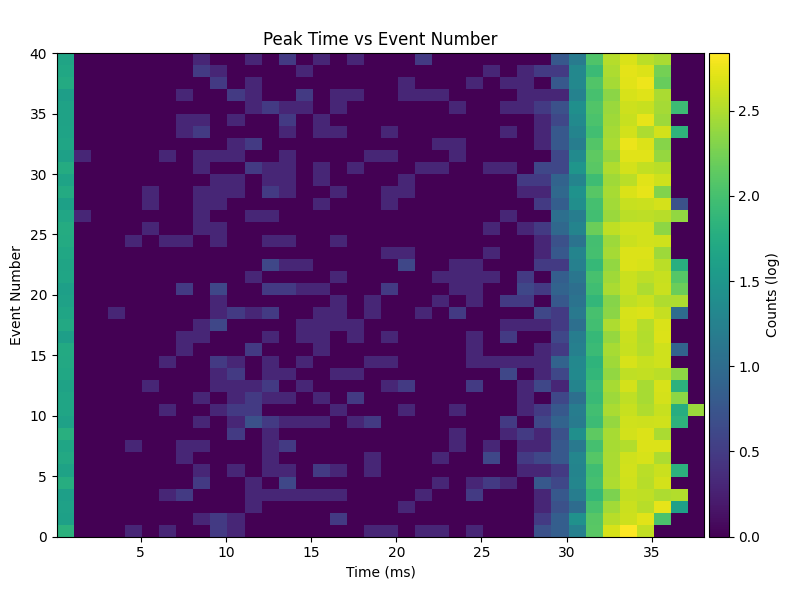

[CH2] Event 1: 1750 peaks heights(1750 from t = 0 to 40000000.0 ns).
[CH2] Event 2: 1575 peaks heights(1575 from t = 0 to 40000000.0 ns).
[CH2] Event 3: 1750 peaks heights(1750 from t = 0 to 40000000.0 ns).
[CH2] Event 4: 1715 peaks heights(1715 from t = 0 to 40000000.0 ns).
[CH2] Event 5: 1715 peaks heights(1715 from t = 0 to 40000000.0 ns).
[CH2] Event 6: 1715 peaks heights(1715 from t = 0 to 40000000.0 ns).
[CH2] Event 7: 1715 peaks heights(1715 from t = 0 to 40000000.0 ns).
[CH2] Event 8: 1750 peaks heights(1750 from t = 0 to 40000000.0 ns).
[CH2] Event 10: 1750 peaks heights(1750 from t = 0 to 40000000.0 ns).
[CH2] Event 11: 1750 peaks heights(1750 from t = 0 to 40000000.0 ns).
[CH2] Event 12: 1890 peaks heights(1890 from t = 0 to 40000000.0 ns).
[CH2] Event 13: 1750 peaks heights(1750 from t = 0 to 40000000.0 ns).
[CH2] Event 14: 1715 peaks heights(1715 from t = 0 to 40000000.0 ns).
[CH2] Event 15: 1715 peaks heights(1715 from t = 0 to 40000000.0 ns).
[CH2] Event 16: 1715 peaks h

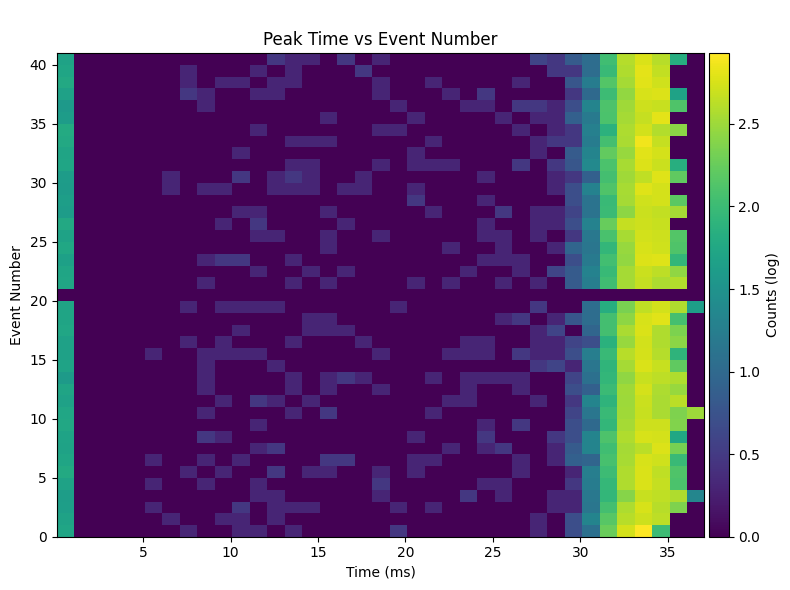

[CH3] Event 1: 1750 peaks heights(1750 from t = 0 to 40000000.0 ns).
[CH3] Event 2: 1575 peaks heights(1575 from t = 0 to 40000000.0 ns).
[CH3] Event 3: 1750 peaks heights(1750 from t = 0 to 40000000.0 ns).
[CH3] Event 4: 1715 peaks heights(1715 from t = 0 to 40000000.0 ns).
[CH3] Event 5: 1715 peaks heights(1715 from t = 0 to 40000000.0 ns).
[CH3] Event 6: 1715 peaks heights(1715 from t = 0 to 40000000.0 ns).
[CH3] Event 7: 1715 peaks heights(1715 from t = 0 to 40000000.0 ns).
[CH3] Event 8: 1750 peaks heights(1750 from t = 0 to 40000000.0 ns).
[CH3] Event 10: 1750 peaks heights(1750 from t = 0 to 40000000.0 ns).
[CH3] Event 11: 1750 peaks heights(1750 from t = 0 to 40000000.0 ns).
[CH3] Event 12: 1890 peaks heights(1890 from t = 0 to 40000000.0 ns).
[CH3] Event 13: 1750 peaks heights(1750 from t = 0 to 40000000.0 ns).
[CH3] Event 14: 1715 peaks heights(1715 from t = 0 to 40000000.0 ns).
[CH3] Event 15: 1715 peaks heights(1715 from t = 0 to 40000000.0 ns).
[CH3] Event 16: 1715 peaks h

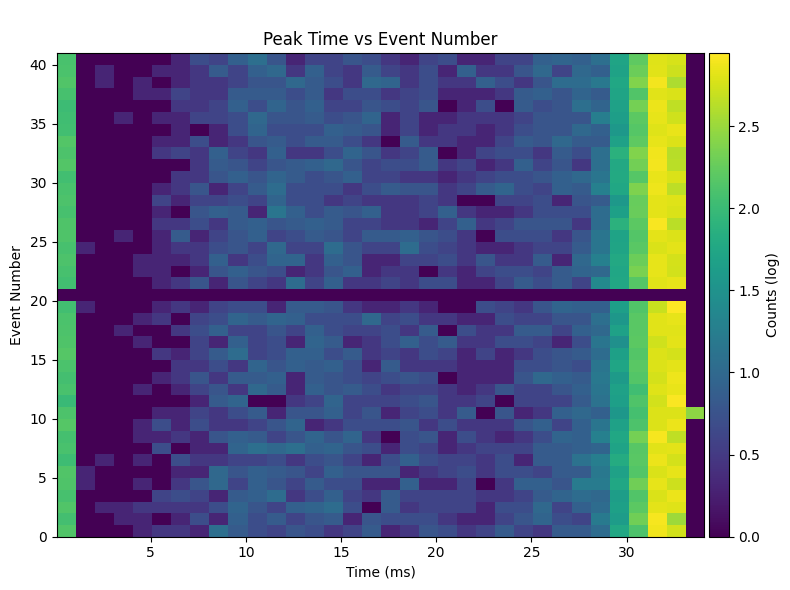

[CH4] Received 0 delta trains
No data in specified t_range; nothing to plot.


In [8]:
from extinction_plots import plot_2d_histogram_time_vs_event_number

def get_delta_train_per_event(channel: int,
                              fft_time_range_ns: tuple[float, float] = (None, None),
                              period=None):
    """
    Get delta train for a specific channel and event.
    :param channel: Channel number (1, 2, or 3).
    :param fft_time_range_ns: Time range for FFT in nanoseconds.
    :return: Delta train and time range for FFT.
    """
    r = get_delta_trains_per_event_from_hex(hc, channel, fft_time_range_ns, units='ns', period=period)
    return r

# t_range_begin_ns = 29.5e6
# t_range = (t_range_begin_ns, t_range_begin_ns + 1695*15)
t_range = (0, 40e6)
print(f"File name: {hc.file_name}")

for i in range(4):
    delta_trains_per_event, fft_time_range_ns_2 = get_delta_train_per_event(channel=i+1,
                                                                            fft_time_range_ns=t_range)
    print(f"[CH{i+1}] Received {len(delta_trains_per_event)} delta trains")


    plot_2d_histogram_time_vs_event_number(
        delta_trains_per_event,
        bin_width = 1,
        units='ms',
        t_range=t_range
    )

In [9]:
def fft(channel: int, delta_train, fft_time_range_ns: tuple[float, float], expected_peak_khz = 590):
    global signal_period
    global length_ns
    global common_title_text
    global zero_padding_ratio

    if use == "real_data":
        if " - Channel" in common_title_text:
            common_title_text = re.sub(r' - Channel \d', f' - Channel {channel}', common_title_text)
        else:
            common_title_text += f" - Channel {channel}"

    # #######################################################
    # Parameter Setup
    # #######################################################
    if not fft_time_range_ns[0]:
        fft_time_range_ns = (delta_train[0], fft_time_range_ns[1])
    if not fft_time_range_ns[1]:
        fft_time_range_ns = (fft_time_range_ns[0], delta_train[-1])

    length_ns = int(delta_train[-1] - delta_train[0])  # total time in ns
    print(f"[CH{channel}] Total time: {length_ns * 1e-6:.3f} ms")
    # to calc. minimum allowed sampling frequency, use Nyquist theorem:
    # know we want to measure 1 / 1695 ns = 590.5 kHz, so we need at least 2 * 590.5 kHz = 1.181 MHz
    # corresponds to a sampling time of 1 / 1.181 MHz = 846.5 ns
    # anything outside of that will be aliased
    theoretical_peak_width: float = 1 / length_ns * 1e6  # kHz, theoretical peak width in kHz
    print(f"[CH{channel}] Expected theoretical peak width: {theoretical_peak_width:.4f} kHz")

    # start creating bins
    n_bins = int(np.round((fft_time_range_ns[1] - fft_time_range_ns[0]) / sample_rate)) + 1
    t = np.arange(n_bins) * sample_rate + fft_time_range_ns[0]  # time bins in ns, starting at first absolute time

    # check too many bins
    if n_bins > 10000000:
        raise Exception(f"Too many bins ({n_bins}). Check your time parameters ({fft_time_range_ns}).")

    bin_counts = np.zeros(len(t)).astype(int)  # initialize bin counts
    zero_start_delta_train = delta_train - (t[0] - t[0] % sample_rate)  # zero start time
    bin_indices = np.round(zero_start_delta_train / sample_rate).astype(int)  # bin indices for each delta
    # add counts to the corresponding bins
    bin_counts[bin_indices] += 1

    # calculate zero_padding ratio based on desired frequncy resolution
    if zero_padding_ratio is None:
        zero_padding_ratio = round(1e6 / length_ns / desired_f_resolution)  # zero padding ratio
    zero_padded_width = 1 / (length_ns * zero_padding_ratio) * 1e6
    print(f"[CH{channel}] Zero padding ratio: {zero_padding_ratio} (to achieve {zero_padded_width:.4f} kHz "
          f"interpolated resolution)")

    # #######################################################
    # FFT Calculation
    # #######################################################

    # optional, apply window if you wish
    # sometimes helps, sometimes doesn't
    # window = windows.hann(len(bin_counts))
    # bin_counts *= window  # Apply a Hann window to the signal

    # Take the FFT
    amp_exponent = 1  # exponent for amplitude, can be 1 for amplitude or 2 for power spectrum
    fft_result = 1 / len(t) * np.fft.fft(bin_counts, n=zero_padding_ratio * len(t))
    fft_abs = np.abs(fft_result) ** amp_exponent
    fft_freqs = np.fft.fftfreq(len(fft_result), d=sample_rate * 1e-6)  # convert to kHz
    unpadded_df = 1 / (sample_rate * 1e-6) / len(bin_counts)

    # keep positive frequencies only
    fft_abs = fft_abs[:len(fft_abs) // 2]
    fft_freqs = fft_freqs[:len(fft_freqs) // 2]
    # mask out DC component (bottom 1%)
    print("Cutting off freqs below", fft_freqs * 0.001, "kHz")
    fft_mask = fft_freqs >= fft_freqs * 0.001
    fft_abs = fft_abs[fft_mask]
    fft_freqs = fft_freqs[fft_mask]

    # mini range from just above 589 kHz to just below 591 kHz
    search_window_factor = 8
    # search_window_factor = 80
    if expected_peak_khz:
        f_range = (expected_peak_khz - search_window_factor * theoretical_peak_width,
                   expected_peak_khz + search_window_factor * theoretical_peak_width)
    else:
        # search whole frequency range
        f_range = (-np.inf, np.inf)
    fft_mask = (f_range[0] <= fft_freqs) & (fft_freqs <= f_range[1])
    mini_fft_abs = fft_abs[fft_mask]
    mini_fft_freqs = fft_freqs[fft_mask]
    max_idx = np.argsort(mini_fft_abs)[::-1][0]  # Get index of highest bin in mini_fft_abs
    fft_f = mini_fft_freqs[max_idx]  # the frequency FFT bin of the peak
    fft_amp = mini_fft_abs[max_idx]  # amp of that peak
    print(f"[CH{channel}] FFT Peak Frequency: {fft_f:.3f} kHz, Amplitude: {fft_amp:.3f} "
          f"(searched between {mini_fft_freqs[0]:.3f} kHz and {mini_fft_freqs[-1]:.3f} kHz)")

    # #######################################################
    # FFT Peak Fitting
    # #######################################################

    # pull out just the +/- 0.5 kHz around peak for the fit
    fft_fit_window_mask = (np.abs(mini_fft_freqs - fft_f) < theoretical_peak_width * 5)  # +/- 0.5 kHz
    freq_window = mini_fft_freqs[fft_fit_window_mask]
    amp_window = mini_fft_abs[fft_fit_window_mask]

    # do fit
    p0 = [fft_amp, fft_f, theoretical_peak_width, 0]
    popt, pcov = curve_fit(lorentzian, freq_window, amp_window, p0=p0, maxfev=10000)
    A_fit, detected_frequency, sigma_fit, offset_fit = popt

    # calculate period from detected fit frequency
    detected_period = 1 / detected_frequency * 1e6  # ns, looks like 1694.99 ns

    # uncertainty in detected frequency
    detected_frequency_error = np.sqrt(np.diag(pcov))[1]  # second element is frequency
    # propagate to period error
    period_fit_error = detected_frequency_error / (detected_frequency ** 2) * 1e6  # ns

    final_channel_error = report_results_with_error(fft_freqs, fft_abs, unpadded_df, mini_fft_abs, max_idx,
                                                    zero_padding_ratio, detected_frequency,
                                                    length_ns, detected_period, detected_frequency_error, channel)

    # #######################################################
    # Plot FFT Peak / Fitting Result
    # #######################################################

    plot_fft_peak(mini_fft_freqs, mini_fft_abs, freq_window, amp_window, popt, amp_exponent,
                  common_title_text, delta_train, detected_frequency, detected_period, fft_time_range_ns,
                  file_name = f"img/{hc.folder_name}/fft_peak.png",
                  title = (f"FFT Peak Fitting Result - Time Range: {delta_train[0] * 1e-6:.2f} to "
                            f"{delta_train[-1] * 1e-6:.2f} ms"),
                  figsize=(8, 3),
                  )

    return delta_train, detected_period, final_channel_error

[CH1] Using real data from channel 1 with 68425 events.
[CH1] First event time: 77848.00 ns, 
77836 37471564

[CH2] Using real data from channel 2 with 68426 events.
[CH2] First event time: 77844.00 ns, 
77812 36908852

[CH3] Using real data from channel 3 with 68426 events.
[CH3] First event time: 77780.00 ns, 
77752 33266372

[CH1] Total time: 37.394 ms
[CH1] Expected theoretical peak width: 0.0267 kHz
[CH1] Zero padding ratio: 5 (to achieve 0.0053 kHz interpolated resolution)
Cutting off freqs below [0.00000000e+00 5.34847794e-06 1.06969559e-05 ... 1.24999984e+02
 1.24999989e+02 1.24999995e+02] kHz
[CH1] FFT Peak Frequency: 589.991 kHz, Amplitude: 0.005 (searched between 589.787 kHz and 590.210 kHz)
[CH1] Signal power: 2.494e-05 W, Average noise bin: 3.256e-10 W, Noise density: 1.218e-11 W/Hz, SNR: 2048603.96 (T = 37.393728 ms, zero padding ratio = 5)
[CH1] Fitted frequency: 589.991 ± 0.0001 ± 0.0005 kHz (SNR error, fit error)
[CH1] Fitted period: 1694.9417 ± 0.0003 ± 0.0013 ns (SNR

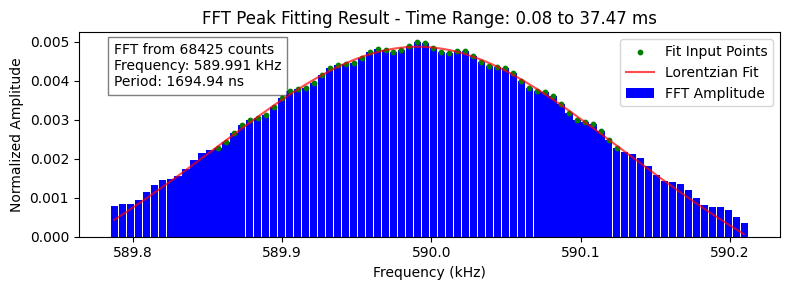


[CH2] Total time: 36.831 ms
[CH2] Expected theoretical peak width: 0.0272 kHz
[CH2] Zero padding ratio: 5 (to achieve 0.0054 kHz interpolated resolution)
Cutting off freqs below [0.00000000e+00 5.34847794e-06 1.06969559e-05 ... 1.24999984e+02
 1.24999989e+02 1.24999995e+02] kHz
[CH2] FFT Peak Frequency: 589.991 kHz, Amplitude: 0.005 (searched between 589.787 kHz and 590.215 kHz)
[CH2] Signal power: 2.195e-05 W, Average noise bin: 3.102e-10 W, Noise density: 1.160e-11 W/Hz, SNR: 1892617.86 (T = 36.83104 ms, zero padding ratio = 5)
[CH2] Fitted frequency: 589.990 ± 0.0001 ± 0.0006 kHz (SNR error, fit error)
[CH2] Fitted period: 1694.9427 ± 0.0004 ± 0.0016 ns (SNR error, fit error)


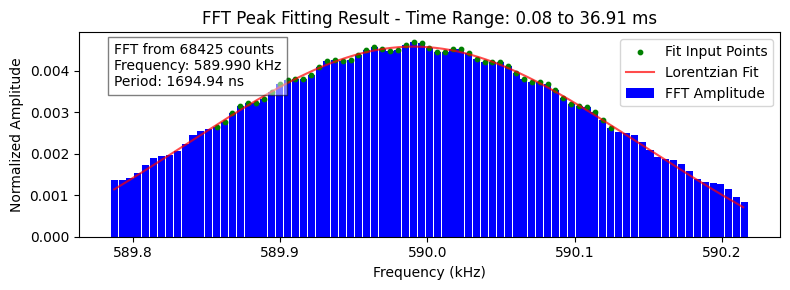


[CH3] Total time: 33.189 ms
[CH3] Expected theoretical peak width: 0.0301 kHz
[CH3] Zero padding ratio: 5 (to achieve 0.0060 kHz interpolated resolution)
Cutting off freqs below [0.00000000e+00 5.34847794e-06 1.06969559e-05 ... 1.24999984e+02
 1.24999989e+02 1.24999995e+02] kHz
[CH3] FFT Peak Frequency: 589.991 kHz, Amplitude: 0.004 (searched between 589.761 kHz and 590.237 kHz)
[CH3] Signal power: 1.640e-05 W, Average noise bin: 3.470e-10 W, Noise density: 1.298e-11 W/Hz, SNR: 1263794.83 (T = 33.18862 ms, zero padding ratio = 5)
[CH3] Fitted frequency: 589.989 ± 0.0002 ± 0.0036 kHz (SNR error, fit error)
[CH3] Fitted period: 1694.9463 ± 0.0005 ± 0.0104 ns (SNR error, fit error)


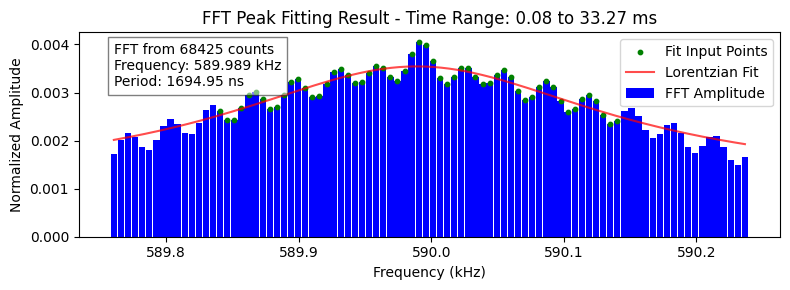


Averaged Period: 1694.943558 ns, Error: 0.001144 ns (std.dev error)
Input mean: 1694.943558360 ns
Weighted mean: 1694.942120991 ns
Weighted error (uncorrelated only): ±0.001046 ns
Chi²/dof: 0.3529 / 2 = 0.1765
Birge ratio: 0.420
Final result: 1694.942120991 ± 0.001046 ns


In [10]:
fft_range = (0e6, 40e6)
ch1, fft_range_1 = get_delta_train(1, fft_range)
# ch1 = np.array([])  # use if ch1 is just the trigger pulse
print()
ch2, fft_range_2 = get_delta_train(2, fft_range)
print()
ch3, fft_range_3 = get_delta_train(3, fft_range)
print()

chs: list[np.ndarray] = []
total_fft_range: tuple[float, float] | tuple[float, float] = (np.inf, -np.inf)
for ch in [ch1, ch2, ch3]:
    if ch.size > 0:
        chs.append(ch)
        # recalculate total min/max range with new ch
        total_fft_range = (min(total_fft_range[0], min(ch)), max(total_fft_range[1], max(ch)))

# Run three FFTs / calculate average period
periods: list[float] = []
period_errors: list[float] = []
delta_trains: list[np.ndarray] = []

for i in range(len(chs)):
    r = fft(i+1,
            chs[i],
            fft_time_range_ns = (total_fft_range[0], total_fft_range[1]),
            expected_peak_khz=590)
    delta_trains.append(r[0])
    periods.append(r[1])
    period_errors.append(r[2])
    print()

# ##########
# COMBINE PERIODS
# ##########
period = float(np.mean(periods))
period_error = np.std(periods) / np.sqrt(len(periods))
print(f"Averaged Period: {period:.6f} ns, Error: {period_error:.6f} ns (std.dev error)")

weighted_period, final_error = combine_periods(period, periods, period_errors)

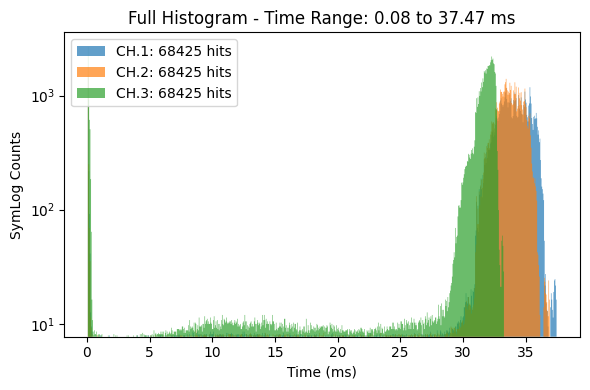

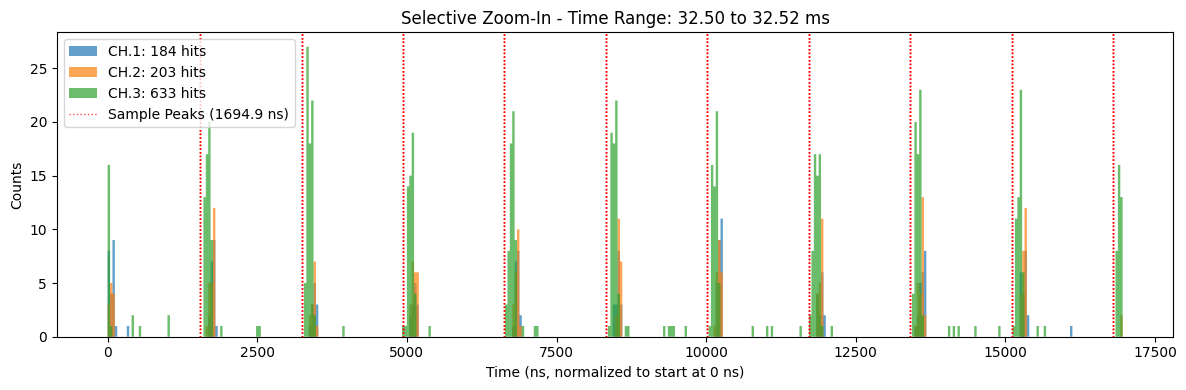

In [11]:
from extinction_plots import plot_1d_histogram

plot_1d_histogram(chs, common_title_text=common_title_text, hist_range=total_fft_range,
                  title=f"Full Histogram - Time Range: {total_fft_range[0] * 1e-6:.2f} to {total_fft_range[1] * 1e-6:.2f} ms",
                  fig_size=(6, 4), file_name=f"img/{hc.folder_name}/full_histogram.png", loc="upper left",
                  log=True, bin_size_ns=0.05e6, alpha=0.7)

# start = 32.5e6 - 32.5e6 % period - 500
start = 32.5e6
offset = 225
start = start - start % period - offset
end = start + period * 10

plot_1d_histogram(chs, common_title_text=common_title_text, include_sample_peaks=True,
                  sample_period=period, hist_range=(start, end), loc="best", alpha=0.7, bin_size_ns=40,
                  fig_size = (12, 4), sample_offset=-150,
                  file_name=f"img/{hc.folder_name}/{hc.file_name}_zoomed_1d_histogram.png",
                  title=f"Selective Zoom-In - Time Range: {start * 1e-6:.2f} to {end * 1e-6:.2f} ms",
                  units='ns')


![hi](../documentation_texts/old/vladimir_beam_loss_slide_1.png)
![hi](../documentation_texts/old/vladimir_beam_loss_slide_2.png)
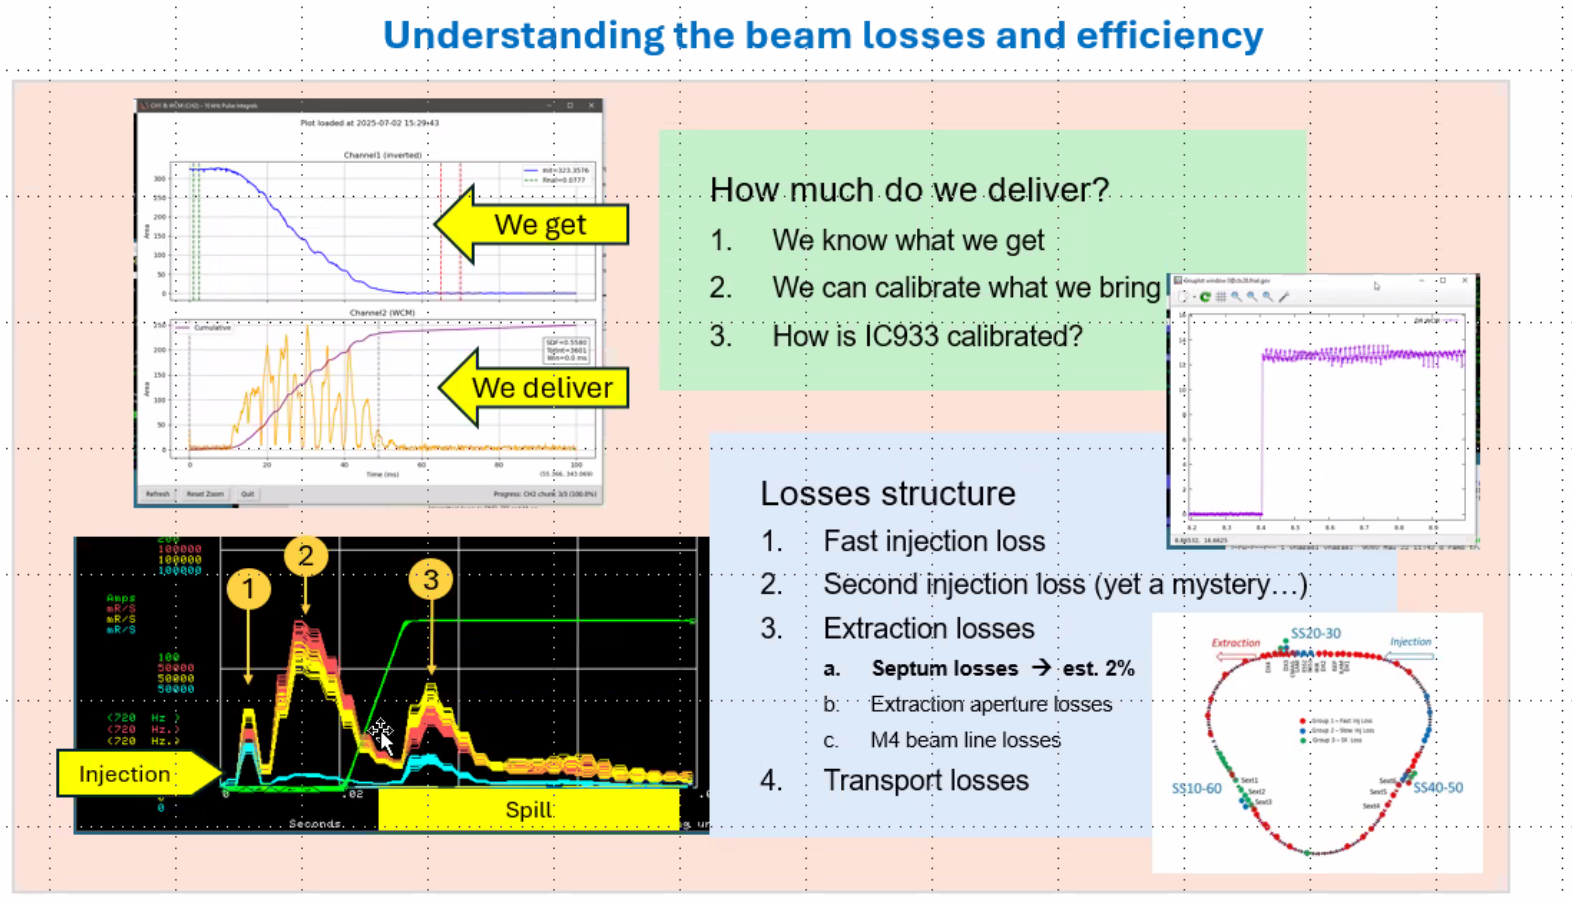
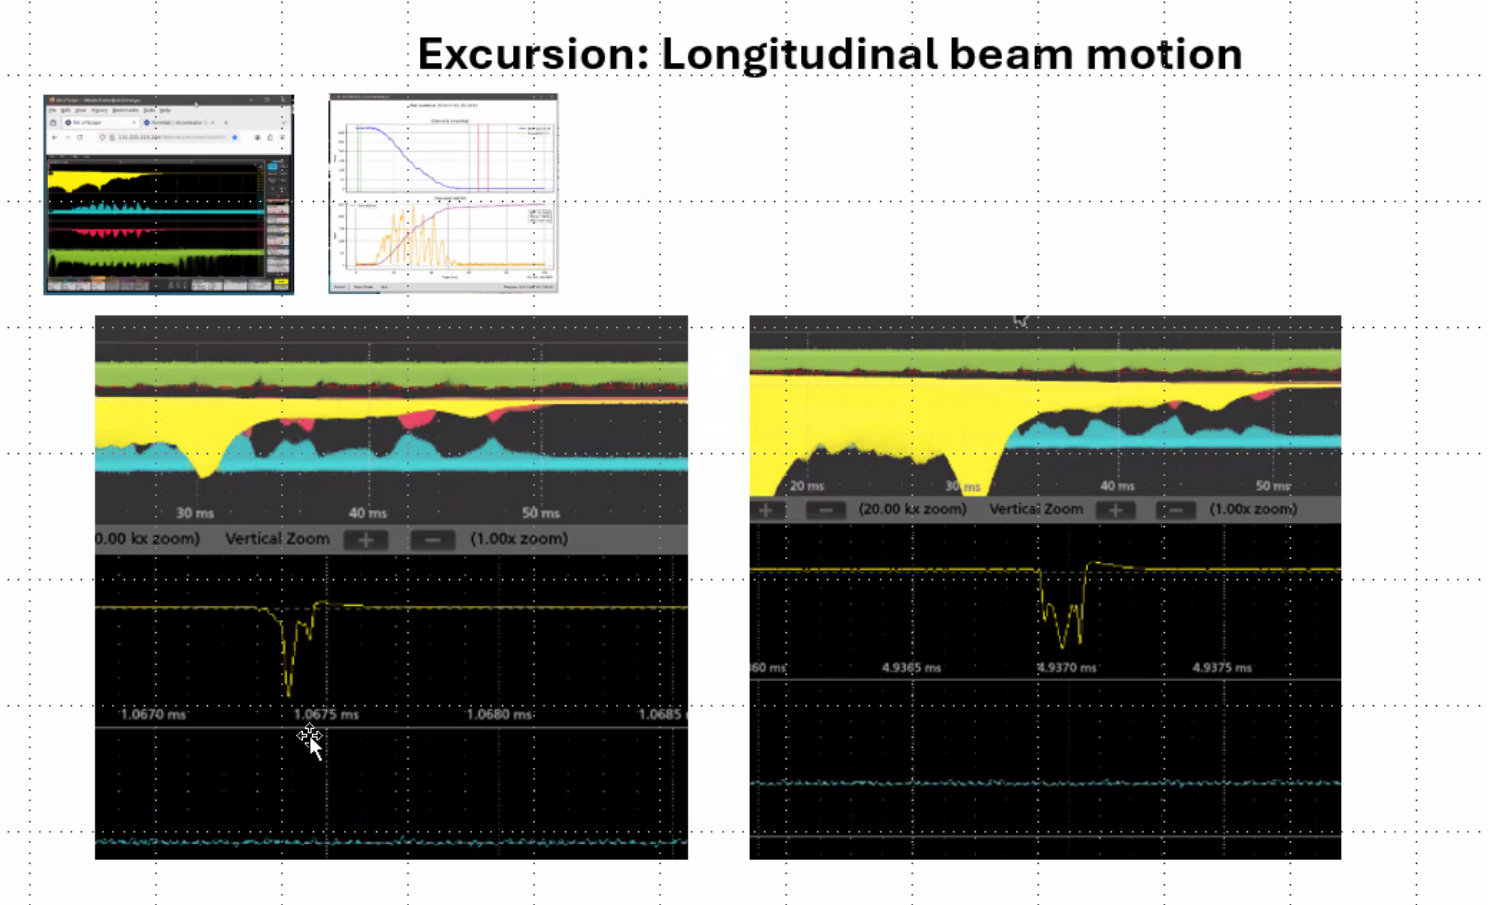
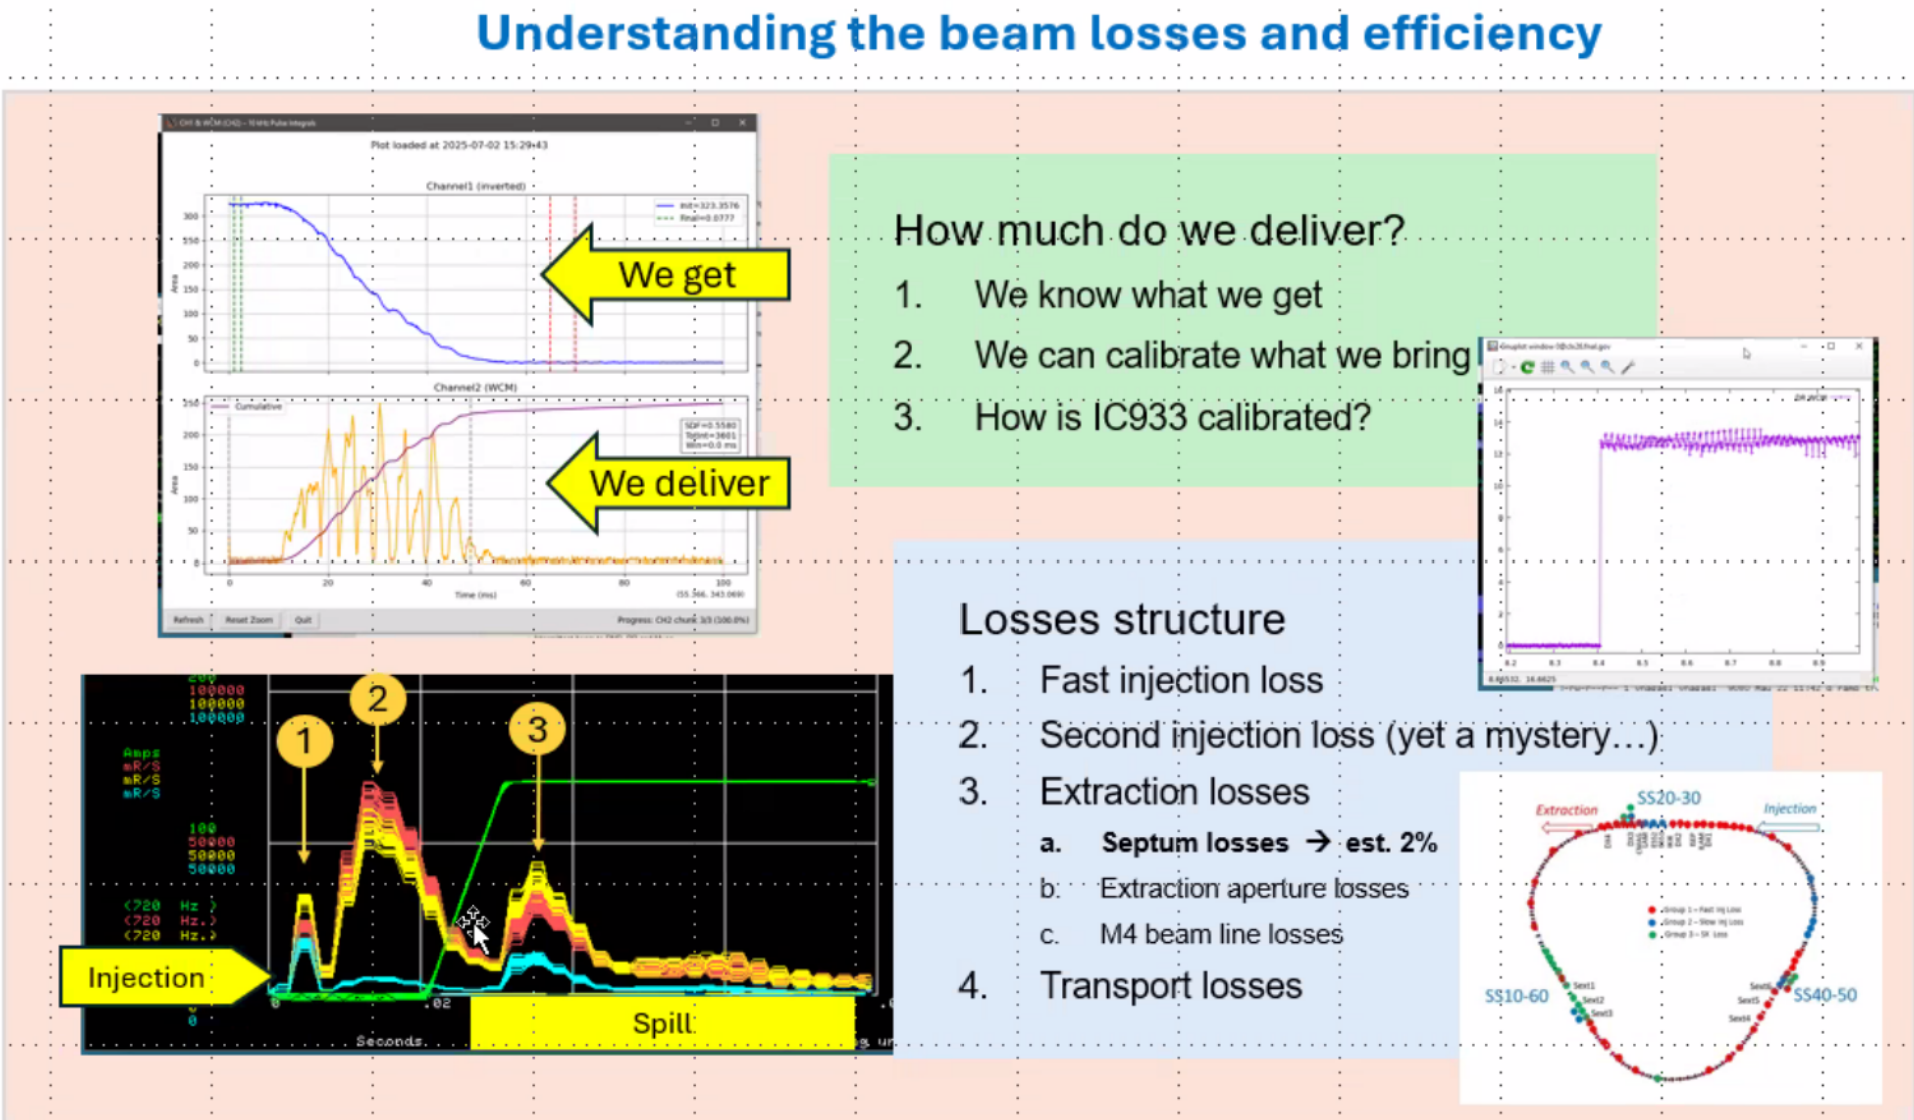

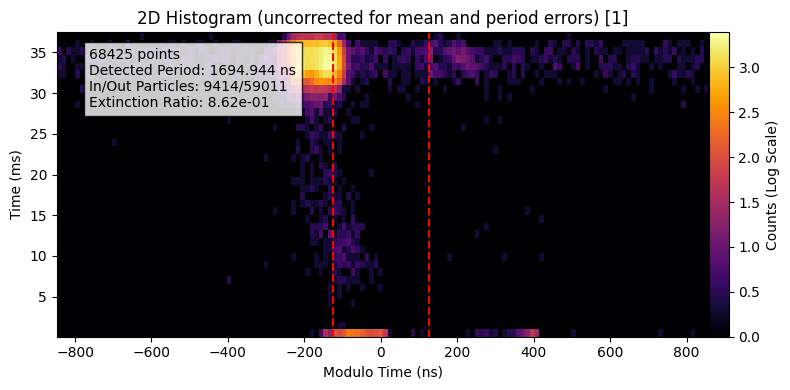

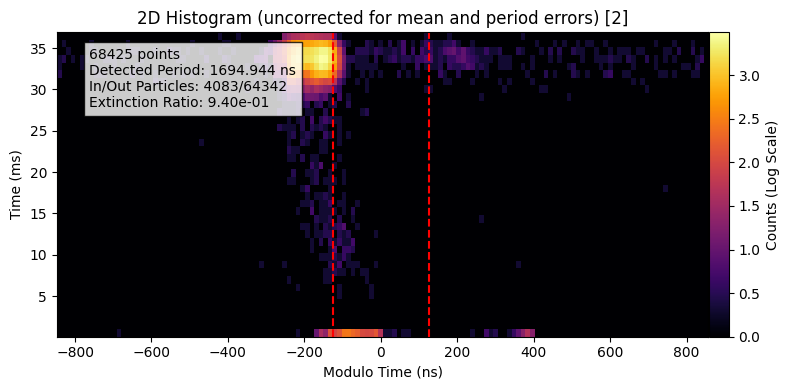

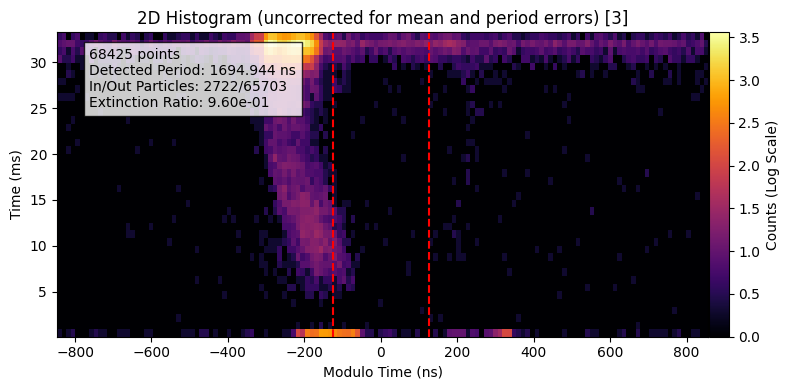

In [12]:
# #######################################################
# PLOT 2D HISTOGRAM
# #######################################################
from extinction_plots import plot_2d_histogram_delta_train

for channel, delta_train in enumerate(delta_trains):
    plot_2d_histogram_delta_train(delta_train, period, common_title_text=common_title_text,
                                  channel = channel + 1,
                                  # file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_2d_histogram_ch{channel+1}.svg",
                                  file_name=f"img/{hc.folder_name}/2d_histogram_uncorrected.png",
                                  bin_width_ns = 12,
                                  n_slices=40,
                                  figsize=(8, 4), colors = ['inferno'],
                                  title=f"2D Histogram (uncorrected for mean and period errors) [{channel + 1}]")


[CH1] Normalized delta train mean: -158.900 ns, 
[CH2] Normalized delta train mean: -170.700 ns, 
[CH3] Normalized delta train mean: -215.041 ns, 


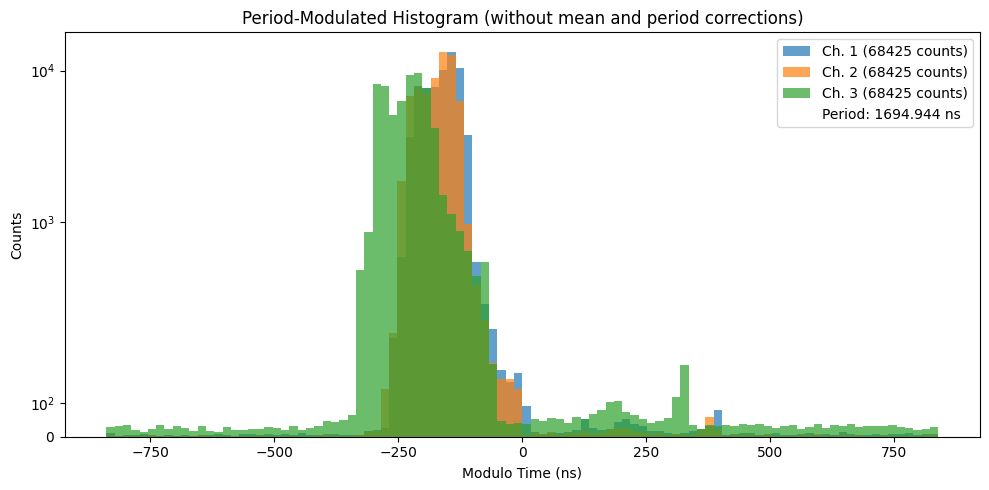

Initial means for each of the three trains: [-158.89965656 -170.7001973  -215.04115455] ns
Delta train mean value (combined channels): -181.55 ns
Starting first 30791/205275 points: [-131 -127 -127 ... -210 -210 -206]
Ending last 30791/205275 points: [-223 -215 -215 ... -238 -206 -285]
Starting mean: -153.93 ns, Ending mean: -227.63 ns, Error: -0.0038 ns, Old Period: 1694.9436 ns, New Period: 1694.9398 ns
Correcting phase of delta train by 78 ns, new mean: -0.07 ns
Correcting phase of (center of) delta train by 29 ns, new mean: -0.11 ns
Starting first 27359/182396 points: [-131 -127 -127 ... -107  -99  -91]
Ending last 27359/182396 points: [-170 -166 -162 ... -181 -164 -132]
Starting mean: -90.92 ns, Ending mean: -143.86 ns, Error: -0.0027 ns, Old Period: 1694.9398 ns, New Period: 1694.9371 ns
Correcting phase of (center of) delta train by 0 ns, new mean: -0.19 ns
Total correction on the mean: 107 ns
Correcting phase of (center of) delta train by -69 ns, new mean: 0.49 ns
Correcting ph

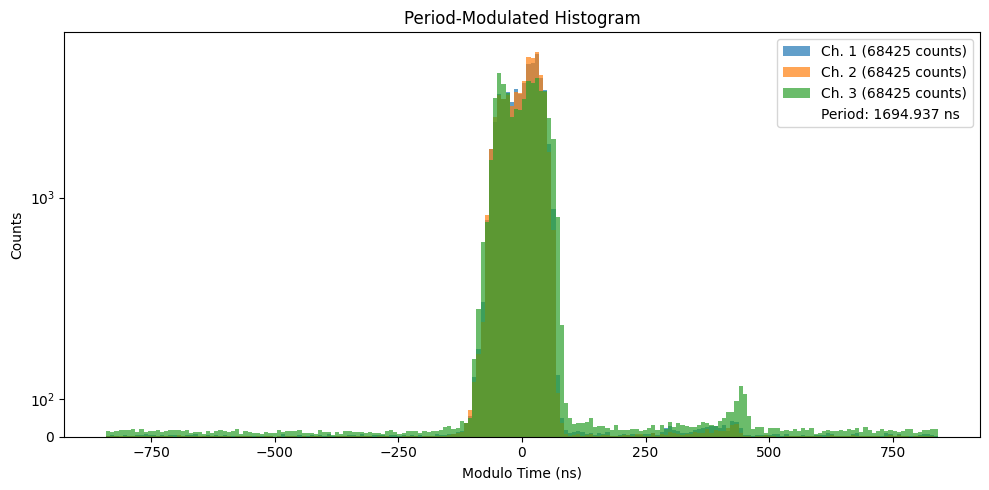

In [23]:
# #######################################################
# Pulse Centering
# #######################################################
from extinction_functions import center_pulses

# period = 1694.943 ... 0284359757
# new_period = 1694.933 0284359758
# new_period = period - 0.01

# normalize delta train by detected period once, but we will slightly nudge it to make it better now
normalized_delta_trains = []
for i, delta_train in enumerate(delta_trains):
    s = symmetric_mod(delta_train, period)
    print(f"[CH{i+1}] Normalized delta train mean: {s.mean():.3f} ns, ")
    normalized_delta_trains.append(s)
new_detected_period = period

# Plot histogram normalized by FFT period
plot_normalized_histogram(delta_trains, normalized_delta_trains, period, figsize=(10, 5),
                          file_name=f"img/{hc.folder_name}/{hc.file_name}_normalized_histogram.svg",
                          title=f"Period-Modulated Histogram (without mean and period corrections)", log=True)

new_delta_trains, new_period = center_pulses(delta_trains, period)
normalized_delta_trains = [symmetric_mod(delta_train, new_period) for delta_train in new_delta_trains]

common_title_text = re.sub(r' - Channel \d', '', common_title_text)  # remove channel number from title

# Plot histogram normalized by FFT period
plot_normalized_histogram(new_delta_trains, normalized_delta_trains, new_period,
                          file_name=f"img/{hc.folder_name}/{hc.file_name}_corrected_normalized_histogram.svg",
                          figsize=(10, 5), log=True, bin_count=200,
                          title = "Period-Modulated Histogram")

[CH2] Event 1: 1750 peaks heights(1750 from t = 0 to 100000000.0 ns).
[CH2] Event 2: 1575 peaks heights(1575 from t = 0 to 100000000.0 ns).
[CH2] Event 3: 1750 peaks heights(1750 from t = 0 to 100000000.0 ns).
[CH2] Event 4: 1715 peaks heights(1715 from t = 0 to 100000000.0 ns).
[CH2] Event 5: 1715 peaks heights(1715 from t = 0 to 100000000.0 ns).
[CH2] Event 6: 1715 peaks heights(1715 from t = 0 to 100000000.0 ns).
[CH2] Event 7: 1715 peaks heights(1715 from t = 0 to 100000000.0 ns).
[CH2] Event 8: 1750 peaks heights(1750 from t = 0 to 100000000.0 ns).
[CH2] Event 10: 1750 peaks heights(1750 from t = 0 to 100000000.0 ns).
[CH2] Event 11: 1750 peaks heights(1750 from t = 0 to 100000000.0 ns).
[CH2] Event 12: 1890 peaks heights(1890 from t = 0 to 100000000.0 ns).
[CH2] Event 13: 1750 peaks heights(1750 from t = 0 to 100000000.0 ns).
[CH2] Event 14: 1715 peaks heights(1715 from t = 0 to 100000000.0 ns).
[CH2] Event 15: 1715 peaks heights(1715 from t = 0 to 100000000.0 ns).
[CH2] Event 16

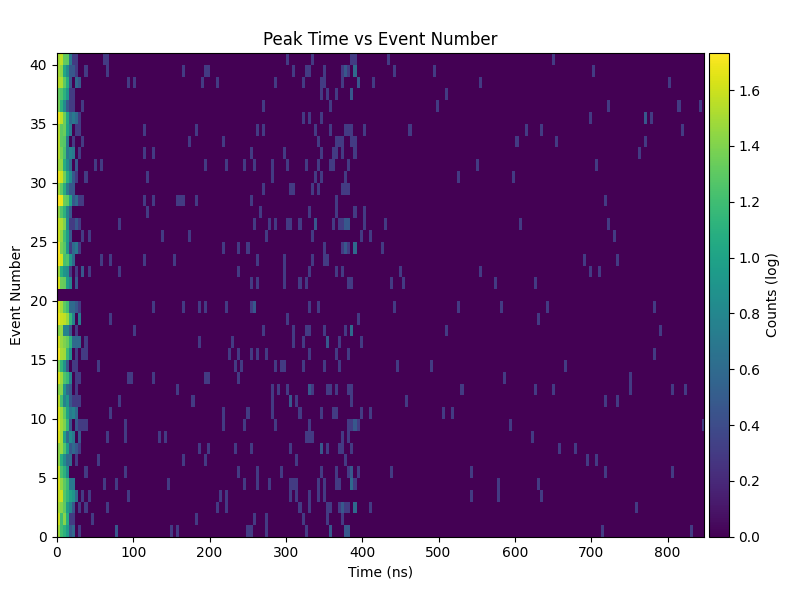

In [14]:
t_range_begin_ns = 0
# t_range = (t_range_begin_ns, t_range_begin_ns + 1695*50)
t_range = (0, 100.e6)
delta_trains_per_event, fft_time_range_ns_2 = get_delta_train_per_event(channel=2,
                                                                        fft_time_range_ns=t_range)

normalized_delta_trains_per_event = [symmetric_mod(delta_train.astype(float), new_period) for delta_train in delta_trains_per_event]


plot_2d_histogram_time_vs_event_number(
    normalized_delta_trains_per_event,
    bin_width = 4,
    units='ns',
    # t_range=t_range
)

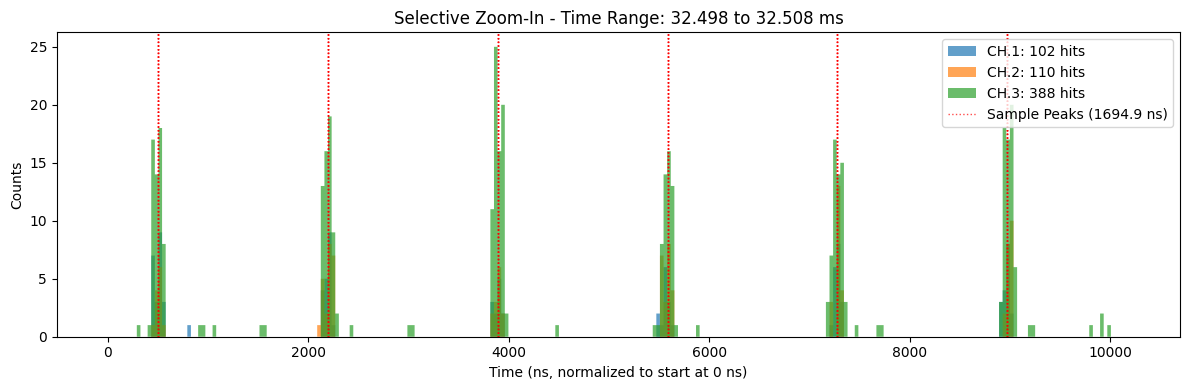

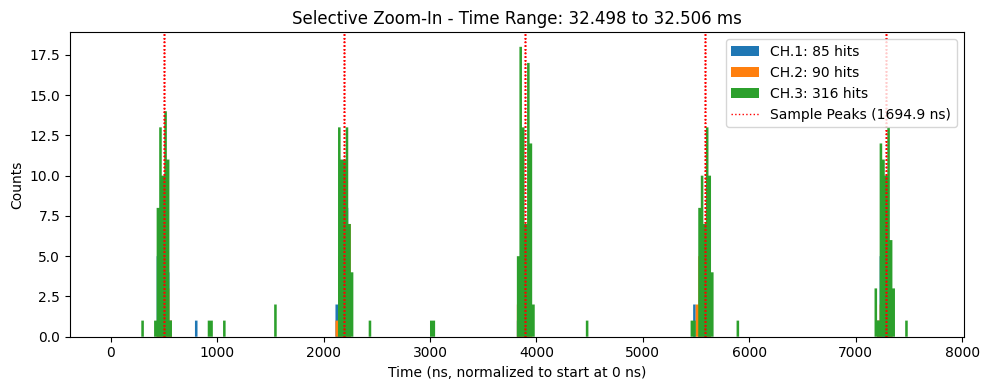

In [15]:
# Check this plot again after period and mean corrections
start = 32.5e6 - 32.5e6 % new_period - 500
end = start + new_period * 6
plot_1d_histogram(new_delta_trains, common_title_text=common_title_text, include_sample_peaks=True,
                  sample_period=new_period, hist_range=(start, end), loc="upper right", alpha=0.7, bin_size_ns=36,
                  fig_size = (12, 4), sample_offset = 500, legend=True,
                  title=f"Selective Zoom-In - Time Range: {start * 1e-6:.3f} to {end * 1e-6:.3f} ms",
                  file_name=f"img/{hc.folder_name}/{hc.file_name}_zoomed_corrected_1d_histogram.svg",
                  units="ns")

end = start + new_period * 4.5
plot_1d_histogram(new_delta_trains, common_title_text=common_title_text, include_sample_peaks=True, sample_offset=500,
                  sample_period=new_period, hist_range=(start, end), loc="upper right", alpha=1, bin_size_ns=24,
                  fig_size=(10, 4), legend=True,
                  # file_name=f"img/{hex_check.folder_name}/zoomed_histogram.png",
                  file_name=f"img/{hc.folder_name}/MOP037_f4.png",
                  title=f"Selective Zoom-In - Time Range: {start * 1e-6:.3f} to {end * 1e-6:.3f} ms")

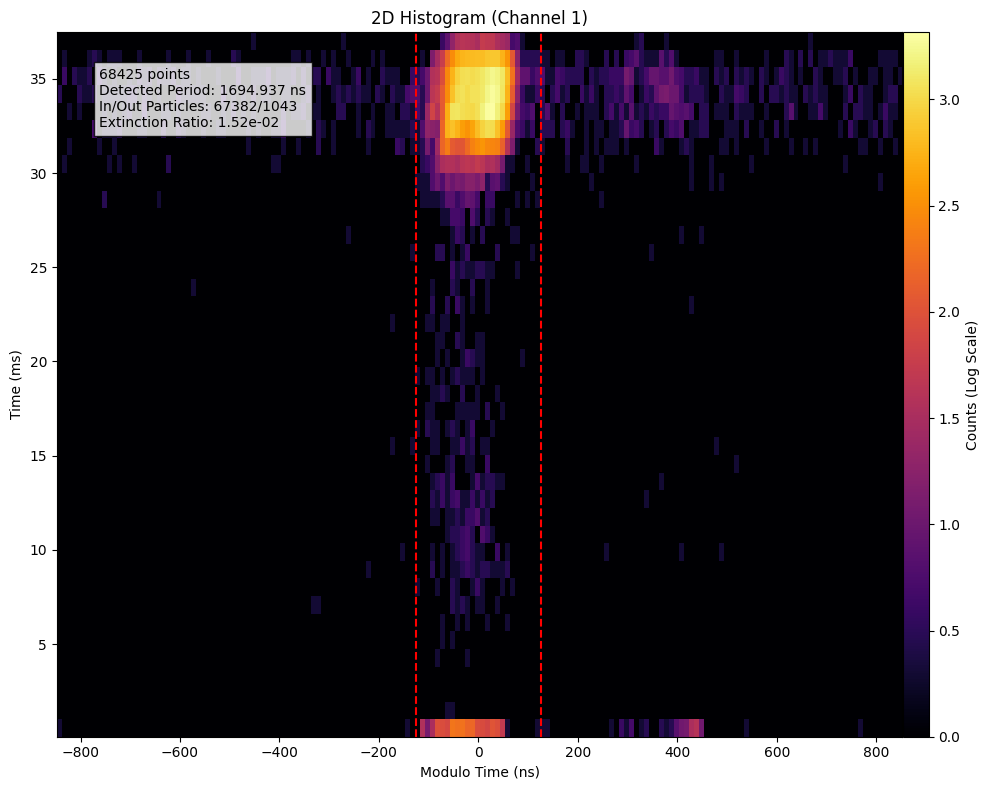

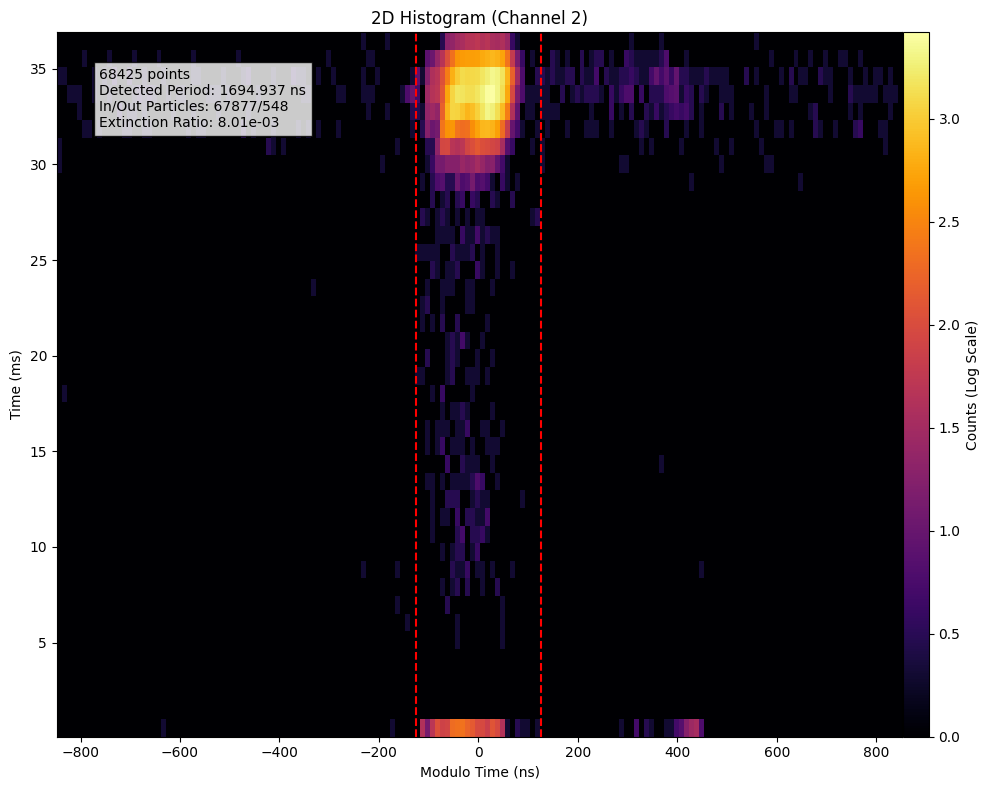

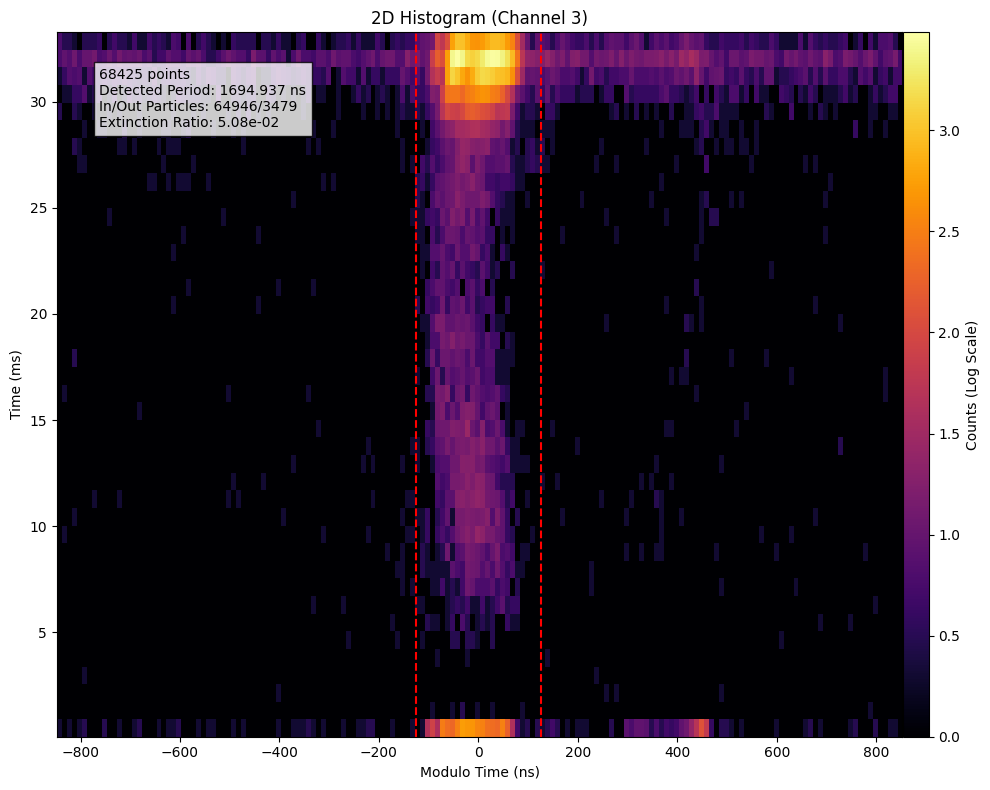

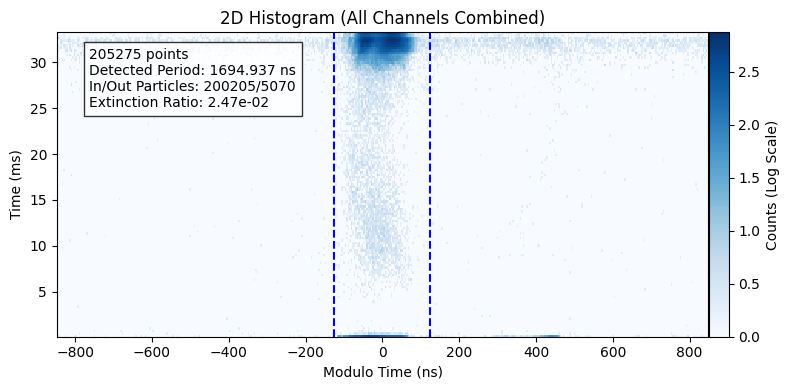

In [24]:
# #######################################################
# PLOT 2D HISTOGRAM
# #######################################################

# fig, ax = plt.subplots(1, 1, figsize=(8, 4))
#
# plot_2d_histogram_delta_train(delta_trains[2], period, common_title_text=common_title_text,
#                               channel = 3, fig_ax = (fig, ax), subplot_no = 1,
#                               colors=['Reds'], bin_width_ns = 4,
#                               n_slices=125, alpha=1,
#                               title = f"2D Histogram, before/after corrections",
#                               )
#
# plot_2d_histogram_delta_train(new_delta_trains[2], new_period, common_title_text=common_title_text,
#                               channel = 3, fig_ax = (fig, ax), subplot_no = 2,
#                               colors=['Greens'], bin_width_ns = 4,
#                               n_slices=125, alpha=0.5,
#                               )
#
# plt.tight_layout()
# plt.savefig(f"img/{hc.folder_name}/2d_hist_comparison.svg", dpi=300, bbox_inches='tight',
#             pad_inches=0)
# plt.savefig(f"img/{hc.folder_name}/MOP037_f6.png", dpi=300, bbox_inches='tight',
#             pad_inches=0)
# plt.show()

for channel, new_delta_train in enumerate(new_delta_trains):
    plot_2d_histogram_delta_train(new_delta_train, new_period, common_title_text=common_title_text,
                                  channel = channel + 1,
                                  # file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_corrected_2d_histogram_ch{channel+1}.svg",
                                  file_name=f"img/{hc.folder_name}/2d_histogram_corrected.png",
                                  colors=['inferno'],
                                  n_slices=40,
                                  figsize=(10, 8),
                                  title=f"2D Histogram (Channel {channel + 1})",
                                  )

all_trains = []
all_trains = np.concatenate(new_delta_trains)  # combine all delta trains into one
plot_2d_histogram_delta_train(all_trains, new_period, common_title_text=common_title_text,
                              channel = 1,
                              # file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_corrected_2d_histogram_ch{channel+1}.svg",
                              file_name=f"img/{hc.folder_name}/2d_histogram_corrected.png",
                              colors=['Blues'],
                              n_slices=125, bin_width_ns=4,
                              figsize=(8, 4),
                              title="2D Histogram (All Channels Combined)",
                              )


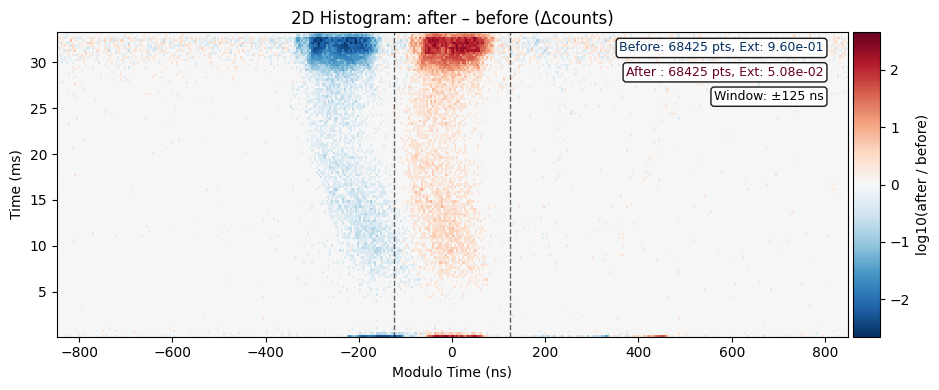

In [17]:
from socketudp.extinction_plots import plot_2d_histogram_delta_train_compare

fig, ax = plt.subplots(1, 1, figsize=(9.5, 4))
plot_2d_histogram_delta_train_compare(
    before_delta=delta_trains[2],
    after_delta=new_delta_trains[2],
    before_period_ns=period,
    after_period_ns=new_period,      # or period; both are fine as long as one is used for binning
    common_title_text=common_title_text,
    fig_ax=(fig, ax),
    bin_width_ns=4,
    n_slices=125,
    mode="ratio",                         # "diff" or "ratio"
    title="2D Histogram: after – before (Δcounts)",
)
plt.tight_layout()
plt.savefig(f"img/{hc.folder_name}/2d_hist_comparison.svg", dpi=300, bbox_inches='tight', pad_inches=0)
plt.savefig(f"img/{hc.folder_name}/MOP037_f6.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()




In [18]:
# #######################################################
# EXTINCTION MEASUREMENT
# #######################################################

for i, normalized_delta_train in enumerate(normalized_delta_trains):
    # define +/- 125 ns window as "in-time", and everything else as "out-of-time"
    in_time_counts = np.sum(np.abs(normalized_delta_train) <= 125)
    out_of_time_counts = len(normalized_delta_train) - in_time_counts
    print(f"[CH{i+1}] In-time counts: {in_time_counts}, Out-of-time counts: {out_of_time_counts}")
    extinction_ratio = out_of_time_counts / (in_time_counts + out_of_time_counts)
    print(f"[CH{i+1}] Extinction ratio: {extinction_ratio:.3e} (out-of-time / total counts)")


[CH1] In-time counts: 67382, Out-of-time counts: 1043
[CH1] Extinction ratio: 1.524e-02 (out-of-time / total counts)
[CH2] In-time counts: 67877, Out-of-time counts: 548
[CH2] Extinction ratio: 8.009e-03 (out-of-time / total counts)
[CH3] In-time counts: 64946, Out-of-time counts: 3479
[CH3] Extinction ratio: 5.084e-02 (out-of-time / total counts)


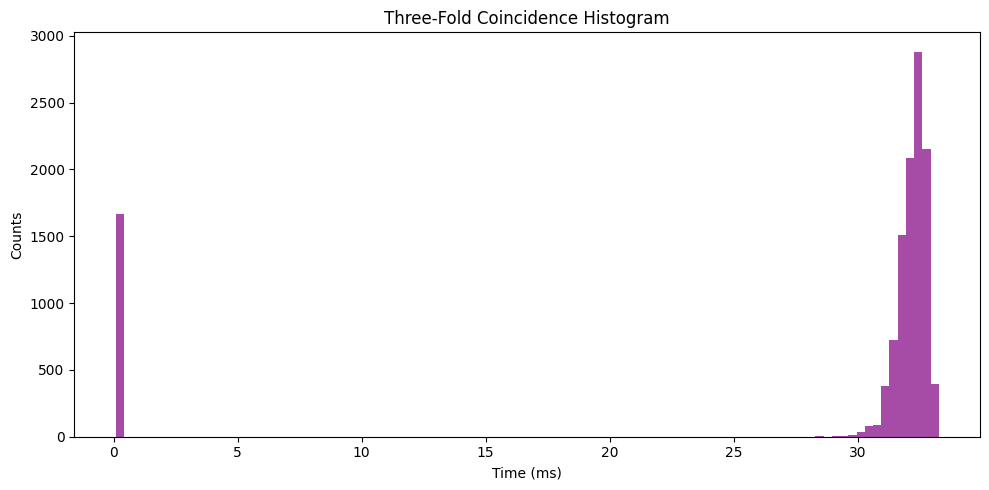

1668 points
Detected Period: 1694.937 ns
In/Out Particles: 1569/99
Extinction Ratio: 5.94e-02
10345 points
Detected Period: 1694.937 ns
In/Out Particles: 10220/125
Extinction Ratio: 1.21e-02


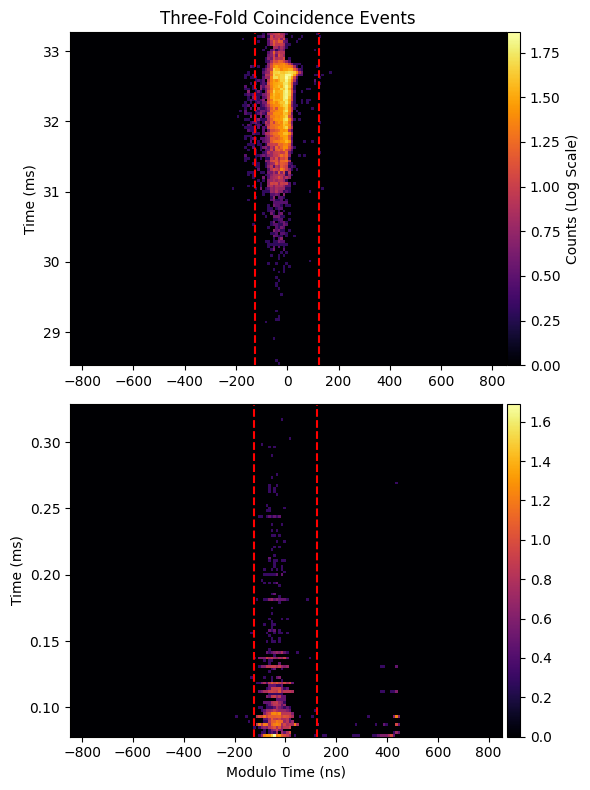

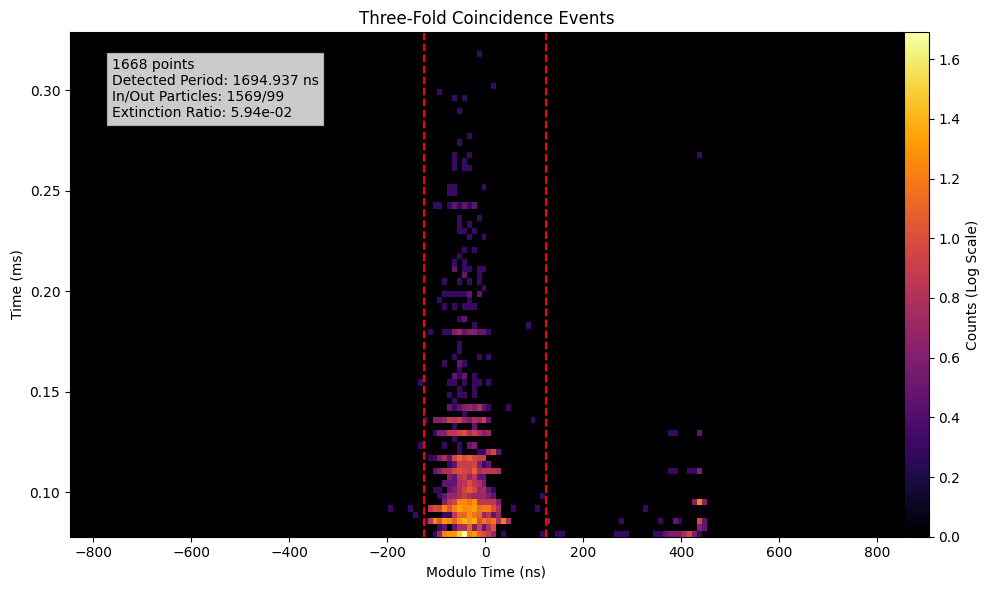

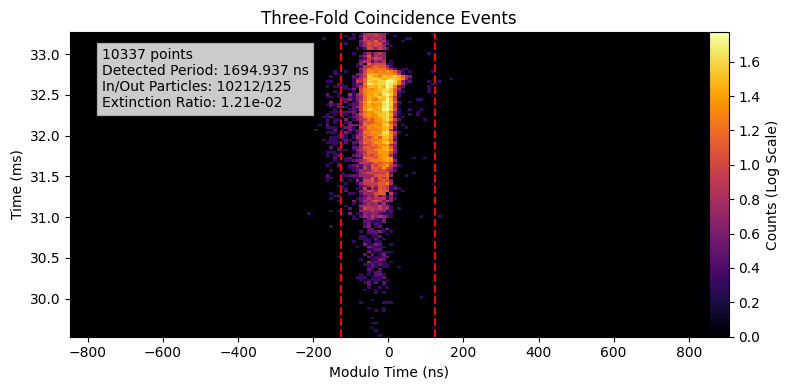

In [19]:
# ############################
# THREE FOLD COINCIDENCE
# ############################

average_points = get_three_fold_coincidence_points(new_delta_trains)

# average points is now a simple list of timestamps, plot on a histogram
if average_points.size > 0:
    three_fold_title = re.sub(r"\nTime Range: .*? ms", "", common_title_text)
    plt.figure(figsize=(10, 5))
    plt.hist(average_points / 1e6, bins=100, color='purple', alpha=0.7)
    plt.xlabel("Time (ms)")
    plt.ylabel("Counts")
    plt.title("Three-Fold Coincidence Histogram")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------

    fig, ax = plt.subplots(2, 1, figsize=(6, 8))

    # Plot two-part combined 2D histogram with disjointed time-axis in same figure
    plot_2d_histogram_delta_train(average_points, new_period, fig_ax = (fig, ax[1]), subplot_no = 2,
                                  common_title_text="Three-Fold Coincidence Events)",
                                  colors=['inferno'],
                                  file_name=f"img/{hc.folder_name}/{hc.file_name}_three_fold_coincidence_2d_histogram.svg", n_slices=120,
                                  figsize=(6, 8), textbox=False, t_range=(0, 2e6))

    plot_2d_histogram_delta_train(average_points, new_period, fig_ax = (fig, ax[0]), subplot_no = 1,
                                  common_title_text="Three-Fold Coincidence Events",
                                  colors=['inferno'], file_name=f"img/{hc.folder_name}/{hc.file_name}_three_fold_coincidence_2d_histogram.svg", n_slices=120,
                                  figsize=(6, 8), textbox=False, t_range=(25e6, np.inf))

    file_name = f"img/{hc.folder_name}/{hc.file_name}_three_fold_coincidence_2d_histogram_combined.svg"
    if file_name:
        plt.savefig(file_name, dpi=300)
    plt.show()

    # ------------------------------------------------------------------

    # plot individual histograms of chosen times
    plot_2d_histogram_delta_train(average_points, new_period,
                                  common_title_text="Three-Fold Coincidence Events",
                                  colors=['inferno'],
                                  # file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_three_fold_coincidence_2d_histogram.svg",
                                  n_slices=80,
                                  figsize=(10, 6), textbox=True, t_range=(0, 2e6))

    plot_2d_histogram_delta_train(average_points, new_period,
                              common_title_text="Three-Fold Coincidence Events",
                              colors=['inferno'], n_slices=120,
                              figsize=(8, 4), textbox=True, t_range=(29.5e6, np.inf))

[CH1] Event 1: 1750 peaks heights(65 from t = 0.0 to 990000.0 ns).
[CH1] Event 2: 1575 peaks heights(40 from t = 0.0 to 990000.0 ns).
[CH1] Event 3: 1750 peaks heights(41 from t = 0.0 to 990000.0 ns).
[CH1] Event 4: 1715 peaks heights(39 from t = 0.0 to 990000.0 ns).
[CH1] Event 5: 1715 peaks heights(57 from t = 0.0 to 990000.0 ns).
[CH1] Event 6: 1715 peaks heights(42 from t = 0.0 to 990000.0 ns).
[CH1] Event 7: 1715 peaks heights(51 from t = 0.0 to 990000.0 ns).
[CH1] Event 8: 1750 peaks heights(45 from t = 0.0 to 990000.0 ns).
[CH1] Event 10: 1750 peaks heights(60 from t = 0.0 to 990000.0 ns).
[CH1] Event 11: 1750 peaks heights(41 from t = 0.0 to 990000.0 ns).
[CH1] Event 12: 1890 peaks heights(45 from t = 0.0 to 990000.0 ns).
[CH1] Event 13: 1750 peaks heights(46 from t = 0.0 to 990000.0 ns).
[CH1] Event 14: 1715 peaks heights(42 from t = 0.0 to 990000.0 ns).
[CH1] Event 15: 1715 peaks heights(48 from t = 0.0 to 990000.0 ns).
[CH1] Event 16: 1715 peaks heights(50 from t = 0.0 to 99

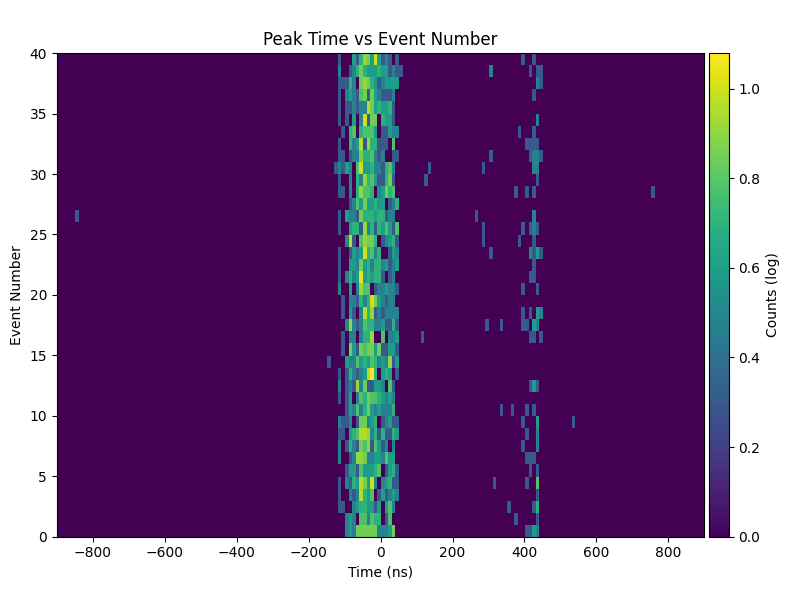

[CH2] Event 1: 1750 peaks heights(52 from t = 0.0 to 990000.0 ns).
[CH2] Event 2: 1575 peaks heights(48 from t = 0.0 to 990000.0 ns).
[CH2] Event 3: 1750 peaks heights(43 from t = 0.0 to 990000.0 ns).
[CH2] Event 4: 1715 peaks heights(42 from t = 0.0 to 990000.0 ns).
[CH2] Event 5: 1715 peaks heights(48 from t = 0.0 to 990000.0 ns).
[CH2] Event 6: 1715 peaks heights(59 from t = 0.0 to 990000.0 ns).
[CH2] Event 7: 1715 peaks heights(51 from t = 0.0 to 990000.0 ns).
[CH2] Event 8: 1750 peaks heights(48 from t = 0.0 to 990000.0 ns).
[CH2] Event 10: 1750 peaks heights(49 from t = 0.0 to 990000.0 ns).
[CH2] Event 11: 1750 peaks heights(56 from t = 0.0 to 990000.0 ns).
[CH2] Event 12: 1890 peaks heights(53 from t = 0.0 to 990000.0 ns).
[CH2] Event 13: 1750 peaks heights(46 from t = 0.0 to 990000.0 ns).
[CH2] Event 14: 1715 peaks heights(50 from t = 0.0 to 990000.0 ns).
[CH2] Event 15: 1715 peaks heights(38 from t = 0.0 to 990000.0 ns).
[CH2] Event 16: 1715 peaks heights(49 from t = 0.0 to 99

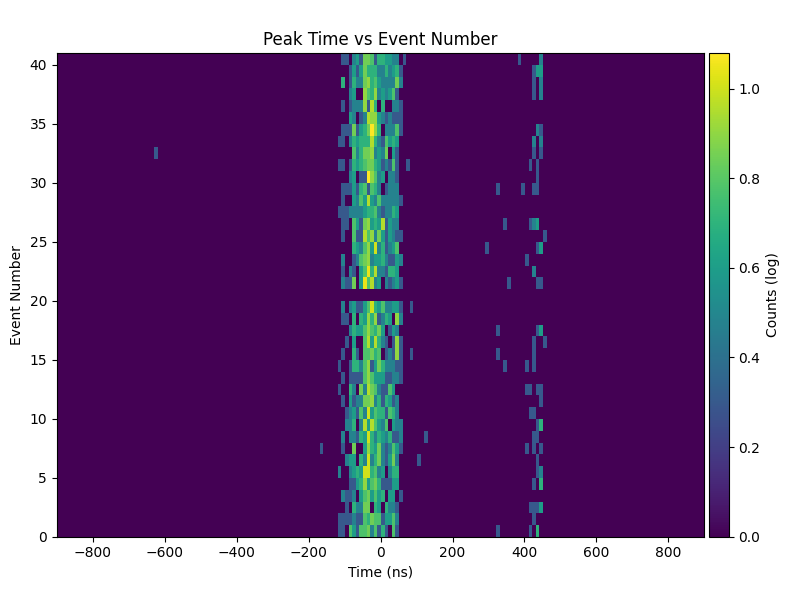

[CH3] Event 1: 1750 peaks heights(140 from t = 0.0 to 990000.0 ns).
[CH3] Event 2: 1575 peaks heights(115 from t = 0.0 to 990000.0 ns).
[CH3] Event 3: 1750 peaks heights(140 from t = 0.0 to 990000.0 ns).
[CH3] Event 4: 1715 peaks heights(120 from t = 0.0 to 990000.0 ns).
[CH3] Event 5: 1715 peaks heights(136 from t = 0.0 to 990000.0 ns).
[CH3] Event 6: 1715 peaks heights(140 from t = 0.0 to 990000.0 ns).
[CH3] Event 7: 1715 peaks heights(105 from t = 0.0 to 990000.0 ns).
[CH3] Event 8: 1750 peaks heights(125 from t = 0.0 to 990000.0 ns).
[CH3] Event 10: 1750 peaks heights(118 from t = 0.0 to 990000.0 ns).
[CH3] Event 11: 1750 peaks heights(146 from t = 0.0 to 990000.0 ns).
[CH3] Event 12: 1890 peaks heights(131 from t = 0.0 to 990000.0 ns).
[CH3] Event 13: 1750 peaks heights(99 from t = 0.0 to 990000.0 ns).
[CH3] Event 14: 1715 peaks heights(123 from t = 0.0 to 990000.0 ns).
[CH3] Event 15: 1715 peaks heights(116 from t = 0.0 to 990000.0 ns).
[CH3] Event 16: 1715 peaks heights(128 from

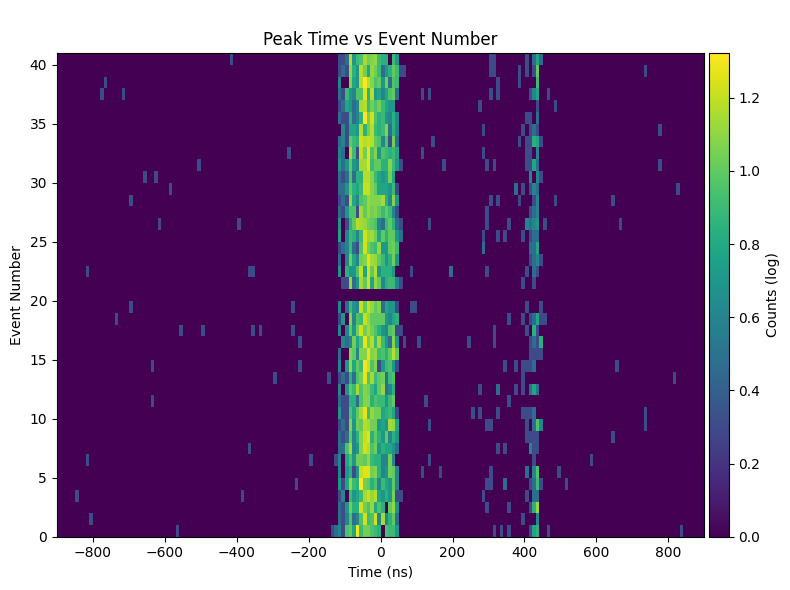

[CH4] Received 0 delta trains


In [20]:
# modulated version of three-fold coincidence plot

for i in range(4):
    delta_trains_per_event, fft_time_range_ns_2 = get_delta_train_per_event(channel=i+1,
                                                                            fft_time_range_ns=(0e6, 0.99e6),
                                                                            period=period)
    print(f"[CH{i+1}] Received {len(delta_trains_per_event)} delta trains")

    # skip if no data
    if len(delta_trains_per_event) == 0:
        continue

    # subtract mean out
    means = []
    for i in delta_trains_per_event:
        if len(i) == 0:
            continue
        means.append(np.mean(i))

    total_mean = np.mean(means)
    new_delta_trains_per_event = []
    for i in delta_trains_per_event:
        new_delta_trains_per_event.append(symmetric_mod(np.array(i) - total_mean, period))


    plot_2d_histogram_time_vs_event_number(
        new_delta_trains_per_event,
        bin_width = 10,
        units='ns',
        t_range=(-900, 900),
        binrange=(-900, 900)
    )